In [2]:
import cv2

video_path = "/kaggle/input/shoplift/Shop DataSet/non shop lifters/shop_lifter_n_33.mp4"

cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total frames
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Video width
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Video height
duration = frame_count / fps if fps > 0 else 0  # Total duration in seconds

cap.release()

# Print the video properties
print(f"Resolution: {width}x{height} pixels")
print(f"FPS: {fps}")
print(f"Total Frames: {frame_count}")
print(f"Duration: {duration:.2f} seconds")


Resolution: 704x576 pixels
FPS: 25.0
Total Frames: 200
Duration: 8.00 seconds


In [3]:
import os
import numpy as np

# Paths to your folders
shoplifter_folder = "/kaggle/input/shoplift/Shop DataSet/shop lifters/"
non_shoplifter_folder = "/kaggle/input/shoplift/Shop DataSet/non shop lifters/"

# Combine both folders
video_folders = [shoplifter_folder, non_shoplifter_folder]

# Store durations
durations = []

for folder in video_folders:
    for video_name in os.listdir(folder):
        video_path = os.path.join(folder, video_name)
        
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if fps > 0:
            duration = frame_count / fps
            durations.append(duration)
        
        cap.release()

# Compute min, max, and average duration
if durations:
    min_duration = np.min(durations)
    max_duration = np.max(durations)
    avg_duration = np.mean(durations)

    print(f"Shortest Video: {min_duration:.2f} seconds")
    print(f"Longest Video: {max_duration:.2f} seconds")
    print(f"Average Video Length: {avg_duration:.2f} seconds")
else:
    print("No valid videos found!")


Shortest Video: 3.00 seconds
Longest Video: 74.00 seconds
Average Video Length: 13.28 seconds


In [12]:
TARGET_SECONDS = 13.28  # Based on dataset average
FPS = 25  
TARGET_FRAMES = int(TARGET_SECONDS * FPS)  
TARGET_SIZE = (224, 224)  # CNN input size

def resize_with_padding(frame, target_size=(224, 224)): #Resize with padding to keep the aspect ratio as the original frames are not square
    h, w = frame.shape[:2]
    target_w, target_h = target_size

    # Compute scaling factor
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize while keeping aspect ratio
    resized_frame = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create a black canvas
    padded_frame = np.zeros((target_h, target_w, 3), dtype=np.uint8)

    # Center the resized frame on the canvas
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    padded_frame[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_frame

    return padded_frame

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frames = []
    
    for i in range(min(total_frames, TARGET_FRAMES)):  # Read up to TARGET_FRAMES
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = resize_with_padding(frame, TARGET_SIZE)  # Use the function correctly
        frame = frame.astype('float32') / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()
    
    # **Padding for Short Videos**
    while len(frames) < TARGET_FRAMES:
        frames.append(frames[-1])  # Duplicate last frame
    
    return np.array(frames)  # Shape: (TARGET_FRAMES, 224, 224, 3)

# Example Usage
video_path = "/kaggle/input/shoplift/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4"
processed_video = process_video(video_path)
print(processed_video.shape)  # Should be (332, 224, 224, 3)


(332, 224, 224, 3)


In [34]:
from tensorflow.keras.utils import Sequence
import cv2
import os
import numpy as np

class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size=8, img_size=(224, 224), frame_count=25, shuffle=True):
        self.video_paths = list(video_paths)  # Ensure it's a list, not a NumPy array
        self.labels = np.array(labels, dtype=np.int32)  # Ensure labels are int32
        self.batch_size = batch_size
        self.img_size = img_size
        self.frame_count = frame_count
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_videos = self.video_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        X, y = self.__data_generation(batch_videos, batch_labels)
        return np.array(X), np.array(y)

    def __data_generation(self, batch_videos, batch_labels):
        X, y = [], []
        for video_path, label in zip(batch_videos, batch_labels):
            frames = self.process_video(video_path)  # Process one video at a time
            X.append(frames)
            y.append(label)
        return np.array(X), np.array(y)

    def process_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_idxs = np.linspace(0, max(1, total_frames - 1), self.frame_count).astype(int)  # Ensure at least 1 frame

        for idx in frame_idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, self.img_size)
            frame = frame / 255.0  # Normalize
            frames.append(frame)

        cap.release()
        
        # Ensure all videos have `FRAME_COUNT` frames (pad if necessary)
        while len(frames) < self.frame_count:
            frames.append(frames[len(frames) % len(frames)])  # Loop existing frames

        return np.array(frames)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.video_paths, self.labels))
            np.random.shuffle(temp)
            self.video_paths, self.labels = zip(*temp)
            self.video_paths = list(self.video_paths)
            self.labels = np.array(self.labels, dtype=np.int32)  # Ensure labels stay as int32



In [35]:
from tensorflow.keras.utils import Sequence
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size=8, img_size=(224, 224), frame_count=25, shuffle=True):
        self.video_paths = np.array(video_paths)  # Ensure it's an array
        self.labels = np.array(labels)  # Ensure it's an array
        self.batch_size = batch_size
        self.img_size = img_size
        self.frame_count = frame_count
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_videos = self.video_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        X, y = self.__data_generation(batch_videos, batch_labels)
        return np.array(X), np.array(y)

    def __data_generation(self, batch_videos, batch_labels):
        X, y = [], []
        for video_path, label in zip(batch_videos, batch_labels):
            frames = self.process_video(video_path)  # Process one video at a time
            if frames is not None:  # Handle cases where the video fails to load
                X.append(frames)
                y.append(label)
        return np.array(X), np.array(y)

    def process_video(self, video_path):
        if not os.path.exists(video_path):  # Check if file exists
            print(f"Warning: File not found {video_path}")
            return None

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Unable to open video {video_path}")
            return None

        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames <= 0:
            print(f"Warning: No valid frames in {video_path}")
            cap.release()
            return None

        frame_idxs = np.linspace(0, max(1, total_frames - 1), self.frame_count).astype(int)

        for idx in frame_idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, self.img_size)
            frame = frame / 255.0  # Normalize
            frames.append(frame)

        cap.release()
        
        # Ensure all videos have `FRAME_COUNT` frames (pad if necessary)
        while len(frames) < self.frame_count:
            frames.append(np.zeros((self.img_size[0], self.img_size[1], 3)))  # Black frame padding

        return np.array(frames)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.video_paths, self.labels))
            np.random.shuffle(temp)
            self.video_paths, self.labels = zip(*temp)
            self.video_paths = np.array(self.video_paths)
            self.labels = np.array(self.labels)

# Set parameters
FRAME_COUNT = 25 # Number of frames per video
IMG_SIZE = (224, 224)  # Resize images
video_folders = {
    "shop lifters": "/kaggle/input/shoplift/Shop DataSet/shop lifters/",
    "non shop lifters": "/kaggle/input/shoplift/Shop DataSet/non shop lifters/"
}

# Collect video file paths and labels
video_paths, labels = [], []

for label, folder in video_folders.items():
    if not os.path.exists(folder):
        print(f"Error: Folder {folder} not found!")
        continue  # Skip if folder doesn't exist

    for video in os.listdir(folder):
        video_path = os.path.join(folder, video)
        if video_path.endswith(('.mp4', '.avi', '.mov')):  # Ensure it's a video file
            video_paths.append(video_path)
            labels.append(1 if label == "shop lifters" else 0)

# Convert to NumPy arrays
video_paths = np.array(video_paths)
labels = np.array(labels, dtype=np.int32)  # Convert labels to integers

# Train-Validation-Test split
X_train, X_temp, y_train, y_temp = train_test_split(video_paths, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert X_train, X_val, X_test to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Print dataset information
unique, counts = np.unique(y_train, return_counts=True)
print(f"Class Distribution: {dict(zip(unique, counts))}")

print("y_train dtype:", y_train.dtype)
print("y_val dtype:", y_val.dtype)
print("y_test dtype:", y_test.dtype)
print("X_train type:", type(X_train))
print("X_train shape:", X_train.shape)
print("X_train sample:", X_train[0])

# Create data generators
batch_size = 8
train_gen = VideoDataGenerator(X_train, y_train, batch_size=batch_size)
val_gen = VideoDataGenerator(X_val, y_val, batch_size=batch_size)
test_gen = VideoDataGenerator(X_test, y_test, batch_size=batch_size)


Class Distribution: {0: 371, 1: 227}
y_train dtype: int32
y_val dtype: int32
y_test dtype: int32
X_train type: <class 'numpy.ndarray'>
X_train shape: (598,)
X_train sample: /kaggle/input/shoplift/Shop DataSet/non shop lifters/shop_lifter_n_141.mp4
Missing files: 0
Batch shape: (8, 25, 224, 224, 3), Labels: [0 0 0 0 0 0 1 1]
X_train dtype: <U82
X_batch shape: (8, 25, 224, 224, 3), dtype: float64
y_batch shape: (8,), dtype: int32


In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.utils.class_weight import compute_class_weight 
# Model Parameters
input_shape = (FRAME_COUNT, 224, 224, 3)  # (Frames, Height, Width, Channels)
learning_rate = 0.001  

# Build the CNN-RNN Model
model = Sequential([
    # 3D CNN for spatial feature extraction
    Conv3D(32, (3,3,3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling3D(pool_size=(1,2,2)),  
    
    Conv3D(64, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(1,2,2)),  
    
    Conv3D(128, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(1,2,2)),  
    
    # Flatten CNN features to feed into LSTM
    TimeDistributed(Flatten()),  

    # LSTM for temporal learning
    LSTM(64, return_sequences=False),  
    
    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate),
    metrics=['accuracy', Recall()]  # Track recall
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,  
    restore_best_weights=True
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weight_dict)  # Check the computed weights


# Train the model with class weights
history = model.fit(
    train_gen, 
    validation_data=val_gen,
    epochs=3
)


# Evaluate model on test set
test_loss, test_acc, test_recall = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test Recall: {test_recall:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class Weights: {0: 0.8059299191374663, 1: 1.3171806167400881}
Epoch 1/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 630s 8s/step - accuracy: 0.5762 - loss: 0.7413 - recall_10: 0.3035 - val_accuracy: 0.6250 - val_loss: 0.6646 - val_recall_10: 0.0000e+00
Epoch 2/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 613s 7s/step - accuracy: 0.5633 - loss: 0.6822 - recall_10: 0.1218 - val_accuracy: 0.6250 - val_loss: 0.6678 - val_recall_10: 0.0000e+00
Epoch 3/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 614s 8s/step - accuracy: 0.5795 - loss: 0.6944 - recall_10: 0.2349 - val_accuracy: 0.6250 - val_loss: 0.6628 - val_recall_10: 0.0000e+00


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - accuracy: 0.6651 - loss: 0.6464 - recall_10: 0.0000e+00
Test Accuracy: 0.6250, Test Recall: 0.0000


In [46]:
X_val = np.array([feat for path in X_val if (feat := extract_features(path)) is not None])

print(X_val.dtypes)  # If using pandas DataFrame
print(type(X_val))   # Check the type of X_val
print(X_val[:5])     # Print first 5 rows to inspect data format


y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Unique predicted classes:", np.unique(y_pred_classes, return_counts=True))


NameError: name 'extract_features' is not defined

In [40]:
print("Train Labels Distribution:", np.bincount(y_train))
print("Validation Labels Distribution:", np.bincount(y_val))
print("First 10 Validation Labels:", y_val[:10])


Train Labels Distribution: [371 227]
Validation Labels Distribution: [80 48]
First 10 Validation Labels: [0 1 0 1 1 1 0 0 0 0]


In [41]:
sample_input = np.expand_dims(X_val[0], axis=0)
sample_pred = model.predict(sample_input)

print("Raw Model Output:", sample_pred)
print("Predicted Class:", np.argmax(sample_pred))


ValueError: Invalid dtype: str2368

## NEW PREPROCESSING


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

In [4]:
# Constants
VIDEO_LENGTH = 13  # seconds
FPS = 25  # frames per second
FIXED_FRAMES = VIDEO_LENGTH * FPS  # Total frames per video
FRAME_SIZE = (224, 224)  # Resize frames
BATCH_SIZE = 4

# Data paths
DATASET_PATH = "/kaggle/input/shoplift/Shop DataSet/"
SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, "shop lifters")
NON_SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, "non shop lifters")


# Function to preprocess video
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Handle short videos (looping)
    while len(frames) < FIXED_FRAMES:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Restart video
        while len(frames) < FIXED_FRAMES:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, FRAME_SIZE) / 255.0  # Normalize
            frames.append(frame)
        if total_frames < FIXED_FRAMES:
            frames = frames[:FIXED_FRAMES]  # Trim if needed

    # Handle long videos (trimming)
    if len(frames) > FIXED_FRAMES:
        frames = frames[:FIXED_FRAMES]

    cap.release()
    return np.array(frames)

# Data Generator
class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size=BATCH_SIZE, shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.video_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_videos = [self.video_paths[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]

        X, y = self.__data_generation(batch_videos, batch_labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_videos, batch_labels):
        X = np.array([preprocess_video(video) for video in batch_videos])
        y = np.array(batch_labels)
        return X, y

# Get video file paths and labels
shoplifter_videos = [os.path.join(SHOPLIFTERS_PATH, vid) for vid in os.listdir(SHOPLIFTERS_PATH) if vid.endswith(".mp4")]
non_shoplifter_videos = [os.path.join(NON_SHOPLIFTERS_PATH, vid) for vid in os.listdir(NON_SHOPLIFTERS_PATH) if vid.endswith(".mp4")]

video_paths = shoplifter_videos + non_shoplifter_videos
labels = [1] * len(shoplifter_videos) + [0] * len(non_shoplifter_videos)

# Split data (80% train, 20% validation)
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(video_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Initialize Generators
train_gen = VideoDataGenerator(train_paths, train_labels)
val_gen = VideoDataGenerator(val_paths, val_labels)

In [ ]:
# CNN-RNN Model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

model = Sequential([
    TimeDistributed(base_model, input_shape=(FIXED_FRAMES, 224, 224, 3)),
    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=False),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Recall()])

# Train Model
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

# Save Model
model.save("shoplifting_detection_model.h5")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


## TRIAL 3

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

# Constants
VIDEO_LENGTH = 13  # seconds
FPS = 25
FIXED_FRAMES = VIDEO_LENGTH * FPS  # 325 frames per video
FRAME_SIZE = (112, 112)  # Resize frames for efficiency
BATCH_SIZE = 4

# Paths
DATASET_PATH = "/kaggle/input/shoplift/Shop DataSet/"
SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, "shop lifters")
NON_SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, "non shop lifters")

# Load Dataset
shoplifter_videos = [os.path.join(SHOPLIFTERS_PATH, vid) for vid in os.listdir(SHOPLIFTERS_PATH) if vid.endswith(".mp4")]
non_shoplifter_videos = [os.path.join(NON_SHOPLIFTERS_PATH, vid) for vid in os.listdir(NON_SHOPLIFTERS_PATH) if vid.endswith(".mp4")]

video_paths = shoplifter_videos + non_shoplifter_videos
labels = [1] * len(shoplifter_videos) + [0] * len(non_shoplifter_videos)

# Split Data (70% Train, 15% Validation, 15% Test)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(video_paths, labels, test_size=0.3, stratify=labels, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


In [2]:
# Preprocessing Function
# Preprocessing Function
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while len(frames) < FIXED_FRAMES:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % 3 == 0:  # Sample every 3rd frame
            frame = cv2.resize(frame, FRAME_SIZE) / 255.0  # Normalize
            frames.append(frame)
        frame_count += 1

    cap.release()

    # Loop short videos
    while len(frames) < FIXED_FRAMES:
        frames.extend(frames[:FIXED_FRAMES - len(frames)])

    return np.array(frames[:FIXED_FRAMES])  # Trim long videos



# Data Generator
class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size=BATCH_SIZE, shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.video_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_videos = [self.video_paths[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]

        X, y = self.__data_generation(batch_videos, batch_labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def __data_generation(self, batch_videos, batch_labels):
        X = np.array([preprocess_video(video) for video in batch_videos])
        y = np.array(batch_labels)
        return X, y

# Initialize Data Generators
train_gen = VideoDataGenerator(train_paths, train_labels)
val_gen = VideoDataGenerator(val_paths, val_labels)
test_gen = VideoDataGenerator(test_paths, test_labels, shuffle=False)  # No shuffling for testing


In [3]:
# CNN-RNN Model (Built from Scratch)
model = Sequential()

# CNN (Feature Extraction)
model.add(TimeDistributed(Conv2D(32, (3, 3), activation="relu", padding="same"), input_shape=(FIXED_FRAMES, 112, 112, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation="relu", padding="same")))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation="relu", padding="same")))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))
# LSTM (Temporal Pattern Recognition)
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))

# Fully Connected Layers
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))  # Binary classification

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Recall()])

# Train Model
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

# Save Model
model.save("shoplifting_detection_from_scratch.h5")

# Evaluate on Test Data
test_loss, test_acc, test_recall = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test Recall: {test_recall:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [ ]:
# Optimized CNN-RNN Model
model = Sequential()

# CNN (Feature Extraction) - Fewer filters & layers
model.add(TimeDistributed(Conv2D(16, (3, 3), activation="relu", padding="same"), input_shape=(FIXED_FRAMES, 64, 64, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation="relu", padding="same")))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))

# LSTM (Temporal Pattern Recognition) - Reduced units
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))

# Fully Connected Layers
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))  # Binary classification

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Recall()])

# Train Model
history = model.fit(train_gen, epochs=5)  # Train for fewer epochs initially

# Save Model
model.save("optimized_shoplifting_detection.h5")

print("Training Complete! 🚀")

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Constants
VIDEO_LENGTH = 13  # seconds
FPS = 25
FIXED_FRAMES = VIDEO_LENGTH * FPS // 3  # Reduce by sampling every 3rd frame (108 frames)
FRAME_SIZE = (64, 64)
BATCH_SIZE = 

# Paths
DATASET_PATH = "/kaggle/input/shoplift/Shop DataSet/"
SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, "shop lifters")
NON_SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, "non shop lifters")

# Load Dataset
shoplifter_videos = [os.path.join(SHOPLIFTERS_PATH, vid) for vid in os.listdir(SHOPLIFTERS_PATH) if vid.endswith(".mp4")]
non_shoplifter_videos = [os.path.join(NON_SHOPLIFTERS_PATH, vid) for vid in os.listdir(NON_SHOPLIFTERS_PATH) if vid.endswith(".mp4")]

video_paths = shoplifter_videos + non_shoplifter_videos
labels = [1] * len(shoplifter_videos) + [0] * len(non_shoplifter_videos)

# Train-Test Split
train_paths, _, train_labels, _ = train_test_split(video_paths, labels, test_size=0.8, stratify=labels, random_state=42)

# Preprocessing Function
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while len(frames) < FIXED_FRAMES:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % 3 == 0:  # Sample every 3rd frame
            frame = cv2.resize(frame, FRAME_SIZE) / 255.0  # Normalize
            frames.append(frame)
        frame_count += 1

    cap.release()

    while len(frames) < FIXED_FRAMES:
        frames.extend(frames[:FIXED_FRAMES - len(frames)])

    return np.array(frames[:FIXED_FRAMES])  # Trim long videos

# Preprocess and Save Dataset
if not os.path.exists("preprocessed_videos.npy"):
    processed_videos = np.array([preprocess_video(video) for video in train_paths])
    np.save("preprocessed_videos.npy", processed_videos)
    np.save("labels.npy", np.array(train_labels))
else:
    processed_videos = np.load("preprocessed_videos.npy")
    train_labels = np.load("labels.npy")

print(f"Preprocessed {len(processed_videos)} videos.")

# CNN-RNN Model
model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), activation="relu", padding="same"), input_shape=(FIXED_FRAMES, 64, 64, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation="relu", padding="same")))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Recall()])

# Train Model
history = model.fit(processed_videos, np.array(train_labels), batch_size=BATCH_SIZE, epochs=5, validation_split=0.2)

# Save Model
model.save("optimized_shoplifting_detection.h5")
print("Training Complete!")


Preprocessed 171 videos.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_1/time_distributed_1_2/strided_slice_7/StridedSliceGrad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-1-7787dcb80b61>", line 88, in <cell line: 88>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 70, in train_step

OOM when allocating tensor with shape[108,8,64,64,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/time_distributed_1_2/strided_slice_7/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_60297]

## Trail 4

In [15]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Dataset paths
DATASET_PATH = "/kaggle/input/shoplift/Shop DataSet/"
SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, "shop lifters")
NON_SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, "non shop lifters")

# Class mapping
class_map = {"shop lifters": 1, "non shop lifters": 0}

# Collect video file paths and labels
video_files, labels = [], []

for class_name, label in class_map.items():
    class_folder = os.path.join(DATASET_PATH, class_name)
    
    if not os.path.exists(class_folder):
        raise ValueError(f"Folder {class_folder} not found!")

    for file in os.listdir(class_folder):
        if file.endswith(('.mp4', '.avi', '.mov')):  # Video formats
            video_files.append(os.path.join(class_folder, file))
            labels.append(label)

# Convert to NumPy arrays
video_files = np.array(video_files)
labels = np.array(labels)

# Split dataset (Train: 70%, Val: 15%, Test: 15%)
train_videos, test_videos, train_labels, test_labels = train_test_split(
    video_files, labels, test_size=0.3, stratify=labels, random_state=42
)

val_videos, test_videos, val_labels, test_labels = train_test_split(
    test_videos, test_labels, test_size=0.5, stratify=test_labels, random_state=42
)


In [16]:
def extract_frames(video_path, num_frames=10, target_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frames = []
    for i in np.linspace(0, total_frames-1, num_frames, dtype=int):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, frame = cap.read()
        if success:
            frame = cv2.resize(frame, target_size)
            frame = frame / 255.0  # Normalize
            frames.append(frame)

    cap.release()
    
    if len(frames) < num_frames:
        # Pad with last frame if video is too short
        frames += [frames[-1]] * (num_frames - len(frames))
    
    return np.array(frames)

# Test extracting frames from one video
sample_video = train_videos[0]
sample_frames = extract_frames(sample_video)
print("Extracted frames shape:", sample_frames.shape)  # Should be (10, 224, 224, 3)


Extracted frames shape: (10, 224, 224, 3)


In [17]:
from tensorflow.keras.metrics import Recall
def video_data_generator(video_paths, labels, batch_size=4, num_frames=10):
    while True:
        for i in range(0, len(video_paths), batch_size):
            batch_videos = video_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            batch_frames = np.array([extract_frames(v, num_frames) for v in batch_videos])

            batch_labels = np.array(batch_labels).astype(np.float32)  # Convert to float
            batch_labels = batch_labels.reshape(-1, 1)  # Ensure shape (batch_size, 1)

            yield batch_frames, batch_labels

# Create generators
BATCH_SIZE = 4  # Keep small since videos are heavy

train_generator = video_data_generator(train_videos, train_labels, batch_size=BATCH_SIZE)
val_generator = video_data_generator(val_videos, val_labels, batch_size=BATCH_SIZE)
test_generator = video_data_generator(test_videos, test_labels, batch_size=BATCH_SIZE)

import numpy as np
from tensorflow.keras.metrics import Recall

import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import Recall

def compute_recall(model, data_generator, steps):
    recall_metric = Recall()

    for _ in range(steps):  # Iterate over all batches
        try:
            images, labels = next(data_generator)  # Get batch
        except StopIteration:
            break  # Stop if the generator is exhausted

        predictions = model.predict(images, verbose=0)

        # Convert predictions to class labels
        pred_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(labels, axis=1)

        # Update recall metric
        recall_metric.update_state(true_labels, pred_labels)

    return recall_metric.result().numpy()



In [4]:
# Get a sample batch
sample_batch, sample_labels = next(train_generator)
print("Batch shape:", sample_batch.shape)  # (BATCH_SIZE, 10, 224, 224, 3)
print("Labels shape:", sample_labels.shape)  # (BATCH_SIZE, 2)


Batch shape: (4, 10, 224, 224, 3)
Labels shape: (4, 2)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling3D
from tensorflow.keras.metrics import Recall

batch = next(iter(train_generator))
print(f"Batch X shape: {batch[0].shape}")
print(f"Batch Y shape: {batch[1].shape}")


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout

model = Sequential([
    Conv3D(32, kernel_size=(2,2,2), activation='relu', padding='same', input_shape=(10, 224, 224, 3)),
    MaxPooling3D(pool_size=(1,2,2)),

    Conv3D(64, kernel_size=(2,2,2), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(1,2,2)),

    Conv3D(128, kernel_size=(2,2,2), activation='relu', padding='same'),  # Keep spatial size larger

    GlobalAveragePooling3D(),  # Replaces Flatten, reduces params
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')  
])

# ==========================
# COMPILING THE MODEL (WITH RECALL)
# ==========================
model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy", Recall(name="recall")])  

model.summary()

# ==========================
# TRAINING
# ==========================
batch_size = 4
train_samples = len(train_videos)
val_samples = len(val_videos)
test_samples = len(test_videos)

steps_per_epoch = max(1, train_samples // batch_size)
validation_steps = max(1, val_samples // batch_size)
 

X_batch, y_batch = next(train_generator)
print(X_batch.shape, y_batch.shape)  

i = 0
for X, y in train_generator:
    print(f"Batch {i}: X shape={X.shape}, y shape={y.shape}")
    i += 1
    if i == 5:  # Stop after 5 batches
        break
print(f"Train samples: {train_samples}, Batch size: {batch_size}")
print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")
i = 0
for X, y in train_generator:
    print(f"Batch {i}: X shape={X.shape}, y shape={y.shape}")
    i += 1
    if i >= steps_per_epoch:
        break

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)




model.save('video_classification_model.h5')

Batch X shape: (4, 10, 224, 224, 3)
Batch Y shape: (4, 2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)                    │ (None, 10, 224, 224, 32)    │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 10, 112, 112, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 10, 112, 112, 64)    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 10, 56, 56, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 10, 56, 56, 128)     │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,682 (389.38 KB)

 Trainable params: 99,682 (389.38 KB)

 Non-trainable params: 0 (0.00 B)

(4, 10, 224, 224, 3) (4, 2)
Batch 0: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 1: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 2: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 3: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 4: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Train samples: 598, Batch size: 4
Steps per epoch: 149, Validation steps: 32
Batch 0: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 1: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 2: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 3: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 4: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 5: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 6: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 7: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 8: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 9: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 10: X shape=(4, 10, 224, 224, 3), y shape=(4, 2)
Batch 11: X shape=(4, 10, 224,

In [8]:
print(train_labels[:10])  # Should print 0s and 1s
print(train_labels.shape) # Should be (num_samples,) or (num_samples, 1)


[0 1 0 1 1 0 0 0 0 1]
(598,)


In [30]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
labels = np.array([0] * 371 + [1] * 227)  # Simulate dataset labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

import numpy as np
from tensorflow.keras.utils import Sequence

class WeightedDataGenerator(Sequence):
    def __init__(self, base_generator, class_weight_dict, steps_per_epoch):
        self.base_generator = base_generator
        self.class_weight_dict = class_weight_dict
        self.steps_per_epoch = steps_per_epoch  # Define number of batches per epoch

    def __len__(self):
        return self.steps_per_epoch  # Define how many batches make an epoch

    def __getitem__(self, index):
        X, Y = next(self.base_generator)  # Get batch data from generator
        sample_weights = np.array([self.class_weight_dict[int(label)] for label in Y])
        return X, Y, sample_weights  # Return (features, labels, sample weights)
weighted_train_generator = WeightedDataGenerator(train_generator, class_weight_dict, steps_per_epoch)



In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling3D
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

batch = next(iter(train_generator))
print(f"Batch X shape: {batch[0].shape}")
print(f"Batch Y shape: {batch[1].shape}")





model = Sequential([
    Conv3D(32, kernel_size=(2,2,2), activation='relu', padding='same', input_shape=(10, 224, 224, 3)),
    MaxPooling3D(pool_size=(1,2,2)),

    Conv3D(64, kernel_size=(2,2,2), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(1,2,2)),

    Conv3D(128, kernel_size=(2,2,2), activation='relu', padding='same'),

    GlobalAveragePooling3D(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

model.compile(
    loss="binary_crossentropy", 
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy", Recall(name="recall")]
)

model.summary()


# ==========================
# TRAINING
# ==========================


print(np.bincount(train_labels.flatten().astype(int)))  # Count 0s and 1s


batch_size = 4
train_samples = len(train_videos)
val_samples = len(val_videos)
test_samples = len(test_videos)

steps_per_epoch = max(1, train_samples // batch_size)
validation_steps = max(1, val_samples // batch_size)
 

X_batch, y_batch = next(train_generator)
print(X_batch.shape, y_batch.shape)  
X_batch, y_batch = next(video_data_generator(train_videos, train_labels, batch_size=4))

print("Batch X shape:", X_batch.shape)  # Expected: (4, 10, 224, 224, 3)
print("Batch Y shape:", y_batch.shape)  # Expected: (4, 1)
print("Batch Y values:", y_batch)       # Expected: Values like [0], [1], [1], [0]




# Compute class weights from the dataset
labels = np.array([0] * 371 + [1] * 227)  # Simulate your dataset labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Train the model with class weights
history = model.fit(
    weighted_train_generator,  # Use the modified generator
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)






model.save('video_classification_model_softmax.h5')

Batch X shape: (4, 10, 224, 224, 3)
Batch Y shape: (4, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_39 (Conv3D)                   │ (None, 10, 224, 224, 32)    │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_26 (MaxPooling3D)      │ (None, 10, 112, 112, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_40 (Conv3D)                   │ (None, 10, 112, 112, 64)    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_27 (MaxPooling3D)      │ (None, 10, 56, 56, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_41 (Conv3D)                   │ (None, 10, 56, 56, 128)     │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_13          │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,553 (388.88 KB)

 Trainable params: 99,553 (388.88 KB)

 Non-trainable params: 0 (0.00 B)

[371 227]
(4, 10, 224, 224, 3) (4, 1)
Batch X shape: (4, 10, 224, 224, 3)
Batch Y shape: (4, 1)
Batch Y values: [[0.]
 [1.]
 [0.]
 [1.]]


<ipython-input-30-8cbf1235f154>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_weights = np.array([self.class_weight_dict[int(label)] for label in Y])


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/149 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.3977 - loss: 0.6937 - recall: 0.7602 - val_accuracy: 0.3750 - val_loss: 0.6987 - val_recall: 1.0000
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.6987 - val_recall: 1.0000
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.4653 - loss: 0.6921 - recall: 0.6989 - val_accuracy: 0.3750 - val_loss: 0.6976 - val_recall: 1.0000
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 271ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.6976 - val_recall: 1.0000
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.4524 - loss: 0.6864 - recall: 0.5980 - val_accuracy: 0.3750 - val_loss: 0.6982 - val_recall: 1.0000


## Trial 5

In [32]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling3D
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam

# ==========================
# COMPUTE CLASS WEIGHTS
# ==========================

train_labels = np.array([0] * 371 + [1] * 227)  # Simulating dataset labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# ==========================
# CUSTOM DATA GENERATOR WITH WEIGHTS
# ==========================

class WeightedDataGenerator(Sequence):
    def __init__(self, base_generator, class_weight_dict, steps_per_epoch):
        self.base_generator = base_generator
        self.class_weight_dict = class_weight_dict
        self.steps_per_epoch = steps_per_epoch  # Number of batches per epoch

    def __len__(self):
        return self.steps_per_epoch  # Defines how many batches per epoch

    def __getitem__(self, index):
        X, Y = next(self.base_generator)  # Get batch data
        Y = np.reshape(Y, (-1, 1))  # Ensure Y is (batch_size, 1)
        sample_weights = np.array([self.class_weight_dict[int(label)] for label in Y.flatten()])
        return X, Y, sample_weights  # Return (features, labels, sample weights)

# Wrap train_generator with the weighted generator
weighted_train_generator = WeightedDataGenerator(train_generator, class_weight_dict, steps_per_epoch)

# ==========================
# CHECK BATCH SHAPES
# ==========================

batch = next(iter(train_generator))
print(f"Batch X shape: {batch[0].shape}")  # Expected: (batch_size, 10, 224, 224, 3)
print(f"Batch Y shape: {batch[1].shape}")  # Expected: (batch_size, 1)

# ==========================
# MODEL DEFINITION
# ==========================

model = Sequential([
    Conv3D(32, kernel_size=(2,2,2), activation='relu', padding='same', input_shape=(10, 224, 224, 3)),
    MaxPooling3D(pool_size=(1,2,2)),

    Conv3D(64, kernel_size=(2,2,2), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(1,2,2)),

    Conv3D(128, kernel_size=(2,2,2), activation='relu', padding='same'),

    GlobalAveragePooling3D(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(
    loss="binary_crossentropy", 
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy", Recall(name="recall")]
)

model.summary()

# ==========================
# TRAINING
# ==========================

# Ensure labels are properly counted
print("Training label distribution:", np.bincount(train_labels.flatten().astype(int)))

# Define batch sizes and steps
batch_size = 4
train_samples = len(train_videos)
val_samples = len(val_videos)

steps_per_epoch = max(1, train_samples // batch_size)
validation_steps = max(1, val_samples // batch_size)

# Check data generator output before training
X_batch, y_batch = next(train_generator)
print("Train Batch X shape:", X_batch.shape)  # Expected: (batch_size, 10, 224, 224, 3)
print("Train Batch Y shape:", y_batch.shape)  # Expected: (batch_size, 1)

# Fetch batch from function-based generator (ensure arguments are correct)
X_batch, y_batch = next(video_data_generator(train_videos, train_labels, batch_size=batch_size))
print("Batch X shape:", X_batch.shape)  # Expected: (batch_size, 10, 224, 224, 3)
print("Batch Y shape:", y_batch.shape)  # Expected: (batch_size, 1)
print("Batch Y values:", y_batch)       # Check class labels

# Train the model with weighted generator
history = model.fit(
    weighted_train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

# ==========================
# SAVE MODEL
# ==========================

model.save('video_classification_model.h5')


Batch X shape: (4, 10, 224, 224, 3)
Batch Y shape: (4, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_42 (Conv3D)                   │ (None, 10, 224, 224, 32)    │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_28 (MaxPooling3D)      │ (None, 10, 112, 112, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_43 (Conv3D)                   │ (None, 10, 112, 112, 64)    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_29 (MaxPooling3D)      │ (None, 10, 56, 56, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_44 (Conv3D)                   │ (None, 10, 56, 56, 128)     │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_14          │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,553 (388.88 KB)

 Trainable params: 99,553 (388.88 KB)

 Non-trainable params: 0 (0.00 B)

Training label distribution: [371 227]
Train Batch X shape: (4, 10, 224, 224, 3)
Train Batch Y shape: (4, 1)
Batch X shape: (4, 10, 224, 224, 3)
Batch Y shape: (4, 1)
Batch Y values: [[0.]
 [0.]
 [0.]
 [0.]]
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/149 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.4979 - loss: 0.6960 - recall: 0.5586 - val_accuracy: 0.3750 - val_loss: 0.6987 - val_recall: 1.0000
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 271ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.6987 - val_recall: 1.0000
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.4420 - loss: 0.6908 - recall: 0.7062 - val_accuracy: 0.3750 - val_loss: 0.6972 - val_recall: 1.0000
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 269ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.6972 - val_recall: 1.0000
Epoch 5/5
126/149 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4189 - loss: 0.6957 - recall: 0.6126

KeyboardInterrupt: 

## Final Trail

In [44]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from sklearn.model_selection import train_test_split

# ------------------------ STEP 1: VIDEO FRAME EXTRACTOR ------------------------
def extract_frames(video_path, max_frames=25, frame_size=(128, 128)):
    """Extracts frames from a video file and resizes them."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(1, total_frames // max_frames)

    count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frame = cv2.resize(frame, frame_size)
            frames.append(frame)
        count += 1
        if len(frames) == max_frames:
            break
    cap.release()

    while len(frames) < max_frames:
        frames.append(np.zeros((*frame_size, 3), dtype=np.uint8))  # Black frame padding

    return np.array(frames)

In [45]:
# ------------------------ STEP 2: DATA GENERATOR ------------------------
class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size=4, max_frames=25, frame_size=(128, 128), shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.max_frames = max_frames
        self.frame_size = frame_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))  # Number of batches per epoch

    def __getitem__(self, index):
        batch_paths = self.video_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = [], []
        for video_path, label in zip(batch_paths, batch_labels):
            frames = extract_frames(video_path, self.max_frames, self.frame_size)
            X.append(frames)
            y.append(label)

        return np.array(X), np.array(y).astype(np.float32)

    def on_epoch_end(self):
        """Shuffles data after each epoch."""
        if self.shuffle:
            combined = list(zip(self.video_paths, self.labels))
            np.random.shuffle(combined)
            self.video_paths, self.labels = zip(*combined)

In [46]:
# ------------------------ STEP 3: LOAD VIDEO FILE PATHS ------------------------
data_dir = "/kaggle/input/shoplift/Shop DataSet/"  # Folder with class subfolders
classes = sorted(os.listdir(data_dir))  # Ensure order is consistent
class_to_idx = {cls: i for i, cls in enumerate(classes)}  # {'class_0': 0, 'class_1': 1}

video_paths, labels = [], []
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    label = class_to_idx[cls]  # Binary label (0 or 1)
    for video_file in os.listdir(cls_path):
        if video_file.endswith(".mp4"):
            video_paths.append(os.path.join(cls_path, video_file))
            labels.append(label)

In [47]:
# ------------------------ STEP 4: SPLIT DATA ------------------------
train_paths, temp_paths, train_labels, temp_labels = train_test_split(video_paths, labels, test_size=0.3, stratify=labels, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Create generators
train_gen = VideoDataGenerator(train_paths, train_labels, batch_size=4)
val_gen = VideoDataGenerator(val_paths, val_labels, batch_size=4)

In [48]:
# ------------------------ STEP 5: BUILD CNN-LSTM MODEL ------------------------
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(30, 128, 128, 3)),
    TimeDistributed(MaxPooling2D(2, 2)),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D(2, 2)),
    TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D(2, 2)),
    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=False),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall()]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:

# ------------------------ STEP 6: TRAIN MODEL ------------------------
history = model.fit(train_gen, validation_data=val_gen, epochs=5)

# ------------------------ STEP 7: EVALUATE MODEL ------------------------
test_gen = VideoDataGenerator(test_paths, test_labels, batch_size=4, shuffle=False)
test_preds = model.predict(test_gen)
test_preds_classes = (test_preds > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_labels, test_preds_classes))

# Save Model
model.save("binary_video_classification_model.h5")

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.6083 - loss: 0.7033 - recall_1: 0.0637 - val_accuracy: 0.6250 - val_loss: 0.6729 - val_recall_1: 0.0000e+00
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5982 - loss: 0.7052 - recall_1: 0.0992 - val_accuracy: 0.6250 - val_loss: 0.6699 - val_recall_1: 0.0000e+00
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6215 - loss: 0.6925 - recall_1: 0.1615 - val_accuracy: 0.6250 - val_loss: 0.6682 - val_recall_1: 0.0000e+00
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5646 - loss: 0.7405 - recall_1: 0.0868 - val_accuracy: 0.6250 - val_loss: 0.6618 - val_recall_1: 0.0000e+00
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.5805 - loss: 0.6865 - recall_1: 0.2663 - val_accuracy: 0.6250 - val_loss: 0.6617 - val_recall_1: 0.0000e+00
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 769ms/step
              precision    recall  f1-score   support

           0       0.62      1.00      0.77

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Trial 6

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


In [12]:

SHOPLIFTER_DIR = '/kaggle/input/shoplift/Shop DataSet/shop lifters'
NON_SHOPLIFTER_DIR = '/kaggle/input/shoplift/Shop DataSet/non shop lifters'


In [13]:
OUTPUT_DIR = '/kaggle/wprking/output'
SHOPLIFTER_OUT = os.path.join(OUTPUT_DIR, "shop_lifters")
NON_SHOPLIFTER_OUT = os.path.join(OUTPUT_DIR, "non_shop_lifters")

os.makedirs(SHOPLIFTER_OUT, exist_ok=True)
os.makedirs(NON_SHOPLIFTER_OUT, exist_ok=True)


In [14]:
TARGET_WIDTH = 112
TARGET_HEIGHT = 112
TARGET_FRAME_COUNT = 25

In [15]:
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

def compute_optical_flow(prev_frame, curr_frame):
    """Extracts motion features using Optical Flow."""
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

In [16]:
def preprocess_video(video_path, output_folder, visualize=False):
    """Processes video, selects high-motion frames, and visualizes results."""
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Skipping corrupt video: {video_path}")
            return

        video_name = os.path.splitext(os.path.basename(video_path))[0]
        extracted_frames = []
        motion_frames = []
        prev_frame = None

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Resize frame
            frame = cv2.resize(frame, (TARGET_WIDTH, TARGET_HEIGHT), interpolation=cv2.INTER_AREA)
            frame = frame.astype(np.float32) / 255.0  # Normalize

            # Motion detection
            fg_mask = bg_subtractor.apply(frame)
            motion_score = np.sum(fg_mask) / (TARGET_WIDTH * TARGET_HEIGHT)

            if motion_score > 5:
                motion_frames.append(frame)

            # Frame stabilization using Optical Flow (TEMPORARILY DISABLED)
            # if prev_frame is not None:
            #     flow = compute_optical_flow(prev_frame, frame)
            #     frame = cv2.remap(frame, flow, None, interpolation=cv2.INTER_LINEAR)

            prev_frame = frame
            extracted_frames.append(frame)

        cap.release()

        # Ensure frames exist
        if len(motion_frames) == 0:
            print(f"Warning: No motion detected in {video_path}. Using normal frames instead.")
            motion_frames = extracted_frames  # Use regular frames

        # Select final 30 frames
        if len(motion_frames) >= TARGET_FRAME_COUNT:
            final_frames = np.array(motion_frames[:TARGET_FRAME_COUNT])
        else:
            final_frames = np.array(motion_frames)
            while len(final_frames) < TARGET_FRAME_COUNT:
                final_frames = np.vstack([final_frames, final_frames[-1:]])  # Duplicate last frame

        # Print shape before saving
        print(f"Processed {video_name}, shape: {final_frames.shape}")

        # Save preprocessed data
        output_file = os.path.join(output_folder, f"{video_name}.npy")
        np.save(output_file, final_frames)

        # Visualization
        if visualize:
            print(f"Visualizing Video: {video_name}")
            plt.figure(figsize=(10, 4))

            # Original Frame
            plt.subplot(1, 3, 1)
            plt.imshow(extracted_frames[0])  # First frame
            plt.title("Original Frame")
            plt.axis("off")

            # Motion Frame
            plt.subplot(1, 3, 2)
            plt.imshow(motion_frames[0] if motion_frames else extracted_frames[0])  # Motion-based frame
            plt.title("Motion-Based Frame")
            plt.axis("off")

            plt.show()

    except Exception as e:
        print(f"Error processing {video_path}: {e}")

In [17]:
def process_dataset(dataset_dir, output_folder, visualize=False):
    """Processes all videos in a directory."""
    video_files = [f for f in os.listdir(dataset_dir) if f.endswith(('.mp4', '.avi', '.mov'))]

    for video_file in tqdm(video_files, desc=f"Processing {dataset_dir}"):
        video_path = os.path.join(dataset_dir, video_file)
        preprocess_video(video_path, output_folder, visualize)


Processed shop_lifter_75, shape: (25, 112, 112, 3)
Visualizing Video: shop_lifter_75


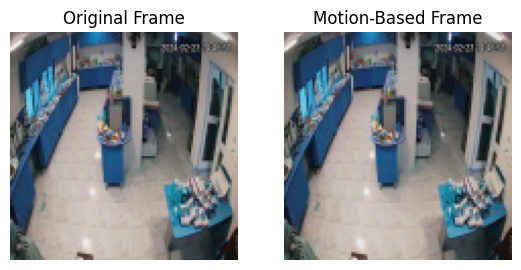

In [18]:
sample_video = os.path.join(SHOPLIFTER_DIR, os.listdir(SHOPLIFTER_DIR)[0])
preprocess_video(sample_video, SHOPLIFTER_OUT, visualize=True)

In [19]:

process_dataset(SHOPLIFTER_DIR, SHOPLIFTER_OUT)
process_dataset(NON_SHOPLIFTER_DIR, NON_SHOPLIFTER_OUT)

print("Advanced Preprocessing & Visualization Complete!")


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   0%|          | 1/324 [00:00<03:46,  1.42it/s]

Processed shop_lifter_75, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   1%|          | 2/324 [00:01<04:51,  1.10it/s]

Processed videyyyyyyzzzzzyyyss_0, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   1%|          | 3/324 [00:02<04:27,  1.20it/s]

Processed shop_lifter_83, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   1%|          | 4/324 [00:03<03:59,  1.33it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_23, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   2%|▏         | 5/324 [00:04<04:31,  1.18it/s]

Processed videppppsss_37, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   2%|▏         | 6/324 [00:04<04:20,  1.22it/s]

Processed videyyyyyyyyyss_50, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   2%|▏         | 7/324 [00:05<04:32,  1.16it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_5, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   2%|▏         | 8/324 [00:06<04:10,  1.26it/s]

Processed videyyyyyyyyyss_8, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   3%|▎         | 9/324 [00:07<03:54,  1.34it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_18, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   3%|▎         | 10/324 [00:08<04:38,  1.13it/s]

Processed videppppsss_39, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   3%|▎         | 11/324 [00:08<04:11,  1.25it/s]

Processed shop_lifter_56, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   4%|▎         | 12/324 [00:09<03:43,  1.39it/s]

Processed videyyyyyyyyyss_35, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   4%|▍         | 13/324 [00:10<04:04,  1.27it/s]

Processed videyyyyyyyyyss_12, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   4%|▍         | 14/324 [00:11<04:29,  1.15it/s]

Processed videppppsss_0, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   5%|▍         | 15/324 [00:12<04:08,  1.24it/s]

Processed videyyyyyyyyyss_31, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   5%|▍         | 16/324 [00:13<04:14,  1.21it/s]

Processed shop_lifter_48, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   5%|▌         | 17/324 [00:14<04:46,  1.07it/s]

Processed videppppsss_34, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   6%|▌         | 18/324 [00:14<04:23,  1.16it/s]

Processed videyyyyyyyyyss_39, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   6%|▌         | 19/324 [00:16<05:25,  1.07s/it]

Processed shop_lifter_39, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   6%|▌         | 20/324 [00:17<04:46,  1.06it/s]

Processed videppppsss_47, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   6%|▋         | 21/324 [00:17<04:20,  1.16it/s]

Processed videyyyyyyyyyss_18, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   7%|▋         | 22/324 [00:18<04:06,  1.23it/s]

Processed videyyyyyyyyyss_51, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   7%|▋         | 23/324 [00:19<04:03,  1.24it/s]

Processed videyyyyyyyyyss_53, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   7%|▋         | 24/324 [00:20<04:22,  1.14it/s]

Processed videyyyyyyzzzzzyyyss_8, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   8%|▊         | 25/324 [00:21<05:02,  1.01s/it]

Processed shop_lifter_99, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   8%|▊         | 26/324 [00:22<04:54,  1.01it/s]

Processed shop_lifter_126, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   8%|▊         | 27/324 [00:23<04:52,  1.01it/s]

Processed videyyyyyyyyyss_46, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   9%|▊         | 28/324 [00:24<05:06,  1.04s/it]

Processed videyyyyyyzzzzzyyyss_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   9%|▉         | 29/324 [00:25<04:36,  1.07it/s]

Processed videmmmmmmsss_91, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:   9%|▉         | 30/324 [00:26<04:49,  1.01it/s]

Processed videppppsss_35, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  10%|▉         | 31/324 [00:27<04:09,  1.18it/s]

Processed shop_lifter_59, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  10%|▉         | 32/324 [00:27<04:09,  1.17it/s]

Processed videppppsss_46, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  10%|█         | 33/324 [00:28<03:43,  1.30it/s]

Processed videyyyyyyyyyss_34, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  10%|█         | 34/324 [00:29<04:04,  1.19it/s]

Processed videppppsss_3, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  11%|█         | 35/324 [00:30<03:58,  1.21it/s]

Processed videyyyyyyyyyss_5, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  11%|█         | 36/324 [00:31<04:05,  1.17it/s]

Processed videyyyyyyyyyss_4, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  11%|█▏        | 37/324 [00:32<04:19,  1.11it/s]

Processed shop_lifter_47, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  12%|█▏        | 38/324 [00:32<03:59,  1.19it/s]

Processed videyyyyyyzzzzzyyyss_3, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  12%|█▏        | 39/324 [00:33<04:09,  1.14it/s]

Processed shop_lifter_87, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  12%|█▏        | 40/324 [00:34<03:53,  1.21it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_13, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  13%|█▎        | 41/324 [00:35<04:19,  1.09it/s]

Processed shop_lifter_23, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  13%|█▎        | 42/324 [00:36<04:15,  1.10it/s]

Processed shop_lifter_8, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  13%|█▎        | 43/324 [00:37<03:59,  1.17it/s]

Processed videppppsss_12, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  14%|█▎        | 44/324 [00:38<04:24,  1.06it/s]

Processed shop_lifter_44, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  14%|█▍        | 45/324 [00:39<04:05,  1.14it/s]

Processed videppppsss_10, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  14%|█▍        | 46/324 [00:39<03:44,  1.24it/s]

Processed videppppsss_40, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  15%|█▍        | 47/324 [00:40<04:02,  1.14it/s]

Processed videppppsss_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  15%|█▍        | 48/324 [00:41<03:50,  1.20it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_29, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  15%|█▌        | 49/324 [00:42<03:57,  1.16it/s]

Processed videyyyyyyzzzzzyyyss_6, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  15%|█▌        | 50/324 [00:43<03:56,  1.16it/s]

Processed videyyyyyyyyyss_62, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  16%|█▌        | 51/324 [00:44<03:37,  1.25it/s]

Processed videyyyyyyyyyss_20, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  16%|█▌        | 52/324 [00:45<04:02,  1.12it/s]

Processed shop_lifter_42, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  16%|█▋        | 53/324 [00:46<04:22,  1.03it/s]

Processed shop_lifter_90, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  17%|█▋        | 54/324 [00:47<04:30,  1.00s/it]

Processed videyyyyyyzzzzzyyyss_12, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  17%|█▋        | 55/324 [00:48<04:40,  1.04s/it]

Processed shop_lifter_95, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  17%|█▋        | 56/324 [00:49<04:14,  1.05it/s]

Processed videyyyyyyyyyss_58, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  18%|█▊        | 57/324 [00:50<04:11,  1.06it/s]

Processed videyyyyyyyyyss_22, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  18%|█▊        | 58/324 [00:51<04:28,  1.01s/it]

Processed videppppsss_36, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  18%|█▊        | 59/324 [00:52<04:05,  1.08it/s]

Processed shop_lifter_77, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  19%|█▊        | 60/324 [00:53<04:13,  1.04it/s]

Processed videppppsss_21, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  19%|█▉        | 61/324 [00:54<04:27,  1.02s/it]

Processed videppppsss_29, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  19%|█▉        | 62/324 [00:55<04:11,  1.04it/s]

Processed shop_lifter_51, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  19%|█▉        | 63/324 [00:55<04:00,  1.09it/s]

Processed videyyyyyyyyyss_25, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  20%|█▉        | 64/324 [00:56<04:09,  1.04it/s]

Processed shop_lifter_94, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  20%|██        | 65/324 [00:57<04:13,  1.02it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_3, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  20%|██        | 66/324 [00:58<03:38,  1.18it/s]

Processed videyyyyyyyyyss_45, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  21%|██        | 67/324 [00:59<03:50,  1.12it/s]

Processed shop_lifter_11, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  21%|██        | 68/324 [01:00<03:41,  1.16it/s]

Processed videyyyyyyyyyss_17, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  21%|██▏       | 69/324 [01:00<02:57,  1.43it/s]

Processed videyyyyyyyyyss_42, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  22%|██▏       | 70/324 [01:02<03:59,  1.06it/s]

Processed shop_lifter_89, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  22%|██▏       | 71/324 [01:02<03:32,  1.19it/s]

Processed videyyyyyyyyyss_26, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  22%|██▏       | 72/324 [01:03<03:38,  1.15it/s]

Processed shop_lifter_67, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  23%|██▎       | 73/324 [01:04<03:42,  1.13it/s]

Processed shop_lifter_125, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  23%|██▎       | 74/324 [01:05<04:12,  1.01s/it]

Processed shop_lifter_32, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  23%|██▎       | 75/324 [01:06<03:54,  1.06it/s]

Processed videppppsss_2, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  23%|██▎       | 76/324 [01:07<03:27,  1.19it/s]

Processed videyyyyyyyyyss_38, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  24%|██▍       | 77/324 [01:08<03:21,  1.23it/s]

Processed shop_lifter_64, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  24%|██▍       | 78/324 [01:08<03:13,  1.27it/s]

Processed shop_lifter_78, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  24%|██▍       | 79/324 [01:09<03:33,  1.15it/s]

Processed videppppsss_16, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  25%|██▍       | 80/324 [01:11<04:01,  1.01it/s]

Processed shop_lifter_5, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  25%|██▌       | 81/324 [01:12<04:01,  1.01it/s]

Processed shop_lifter_53, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  25%|██▌       | 82/324 [01:13<04:12,  1.04s/it]

Processed videppppsss_26, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  26%|██▌       | 83/324 [01:13<03:32,  1.14it/s]

Processed videppppsss_53, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  26%|██▌       | 84/324 [01:14<03:16,  1.22it/s]

Processed shop_lifter_81, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  26%|██▌       | 85/324 [01:15<03:02,  1.31it/s]

Processed videyyyyyyyyyss_54, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  27%|██▋       | 86/324 [01:16<03:18,  1.20it/s]

Processed shop_lifter_109, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  27%|██▋       | 87/324 [01:17<03:33,  1.11it/s]

Processed shop_lifter_17, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  27%|██▋       | 88/324 [01:17<03:26,  1.14it/s]

Processed videmmmmmmsss_89, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  27%|██▋       | 89/324 [01:18<03:24,  1.15it/s]

Processed videyyyyyyyyyss_13, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  28%|██▊       | 90/324 [01:19<02:55,  1.33it/s]

Processed shop_lifter_62, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  28%|██▊       | 91/324 [01:20<03:16,  1.19it/s]

Processed shop_lifter_40, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  28%|██▊       | 92/324 [01:21<03:19,  1.16it/s]

Processed videyyyyyyyyyss_57, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  29%|██▊       | 93/324 [01:22<03:25,  1.12it/s]

Processed shop_lifter_88, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  29%|██▉       | 94/324 [01:22<03:08,  1.22it/s]

Processed videyyyyyyyyyss_36, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  29%|██▉       | 95/324 [01:24<03:46,  1.01it/s]

Processed shop_lifter_16, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  30%|██▉       | 96/324 [01:24<03:18,  1.15it/s]

Processed videppppsss_50, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  30%|██▉       | 97/324 [01:25<03:07,  1.21it/s]

Processed videmmmmmmsss_88, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  30%|███       | 98/324 [01:26<03:26,  1.09it/s]

Processed shop_lifter_14, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  31%|███       | 99/324 [01:27<03:32,  1.06it/s]

Processed shop_lifter_25, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  31%|███       | 100/324 [01:28<03:25,  1.09it/s]

Processed videppppsss_6, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  31%|███       | 101/324 [01:29<02:53,  1.28it/s]

Processed shop_lifter_60, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  31%|███▏      | 102/324 [01:29<03:03,  1.21it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_2, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  32%|███▏      | 103/324 [01:30<02:57,  1.25it/s]

Processed videmmmmmmsss_99, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  32%|███▏      | 104/324 [01:31<02:52,  1.27it/s]

Processed videmmmmmmsss_85, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  32%|███▏      | 105/324 [01:32<02:52,  1.27it/s]

Processed videppppsss_45, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  33%|███▎      | 106/324 [01:33<03:15,  1.12it/s]

Processed shop_lifter_45, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  33%|███▎      | 107/324 [01:34<03:22,  1.07it/s]

Processed shop_lifter_101, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  33%|███▎      | 108/324 [01:35<03:19,  1.08it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_19, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  34%|███▎      | 109/324 [01:36<03:11,  1.12it/s]

Processed videyyyyyyzzzzzyyyss_4, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  34%|███▍      | 110/324 [01:36<03:08,  1.13it/s]

Processed videppppsss_25, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  34%|███▍      | 111/324 [01:37<02:58,  1.19it/s]

Processed videmmmmmmsss_87, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  35%|███▍      | 112/324 [01:38<03:11,  1.11it/s]

Processed shop_lifter_28, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  35%|███▍      | 113/324 [01:39<02:58,  1.18it/s]

Processed videmmmmmmsss_95, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  35%|███▌      | 114/324 [01:40<03:11,  1.10it/s]

Processed shop_lifter_36, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  35%|███▌      | 115/324 [01:41<02:53,  1.20it/s]

Processed shop_lifter_52, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  36%|███▌      | 116/324 [01:41<02:46,  1.25it/s]

Processed videmmmmmmsss_101, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  36%|███▌      | 117/324 [01:42<02:28,  1.39it/s]

Processed videppppsss_54, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  36%|███▋      | 118/324 [01:43<02:47,  1.23it/s]

Processed shop_lifter_93, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  37%|███▋      | 119/324 [01:44<02:32,  1.35it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_16, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  37%|███▋      | 120/324 [01:44<02:30,  1.36it/s]

Processed videyyyyyyzzzzzyyyss_16, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  37%|███▋      | 121/324 [01:45<02:38,  1.28it/s]

Processed videyyyyyyyyyss_6, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  38%|███▊      | 122/324 [01:46<02:31,  1.34it/s]

Processed videyyyyyyyyyss_27, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  38%|███▊      | 123/324 [01:47<02:28,  1.35it/s]

Processed videyyyyyyyyyss_52, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  38%|███▊      | 124/324 [01:47<02:29,  1.34it/s]

Processed videmmmmmmsss_92, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  39%|███▊      | 125/324 [01:48<02:37,  1.26it/s]

Processed videyyyyyyyyyss_7, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  39%|███▉      | 126/324 [01:49<02:42,  1.22it/s]

Processed videyyyyyyyyyss_59, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  39%|███▉      | 127/324 [01:50<02:55,  1.12it/s]

Processed shop_lifter_33, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  40%|███▉      | 128/324 [01:51<03:10,  1.03it/s]

Processed shop_lifter_31, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  40%|███▉      | 129/324 [01:52<03:04,  1.06it/s]

Processed shop_lifter_119, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  40%|████      | 130/324 [01:53<02:43,  1.19it/s]

Processed videyyyyyyzzzzzyyyss_20, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  40%|████      | 131/324 [01:54<02:45,  1.17it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_6, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  41%|████      | 132/324 [01:55<03:10,  1.01it/s]

Processed shop_lifter_120, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  41%|████      | 133/324 [01:56<02:56,  1.09it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_20, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  41%|████▏     | 134/324 [01:56<02:38,  1.20it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_26, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  42%|████▏     | 135/324 [01:57<02:46,  1.14it/s]

Processed shop_lifter_35, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  42%|████▏     | 136/324 [01:58<02:56,  1.07it/s]

Processed videppppsss_8, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  42%|████▏     | 137/324 [01:59<02:42,  1.15it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_27, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  43%|████▎     | 138/324 [02:01<03:13,  1.04s/it]

Processed videppppsss_18, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  43%|████▎     | 139/324 [02:02<03:11,  1.03s/it]

Processed videppppsss_11, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  43%|████▎     | 140/324 [02:03<03:03,  1.00it/s]

Processed shop_lifter_114, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  44%|████▎     | 141/324 [02:03<02:39,  1.15it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_25, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  44%|████▍     | 142/324 [02:04<02:35,  1.17it/s]

Processed videyyyyyyzzzzzyyyss_24, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  44%|████▍     | 143/324 [02:05<03:04,  1.02s/it]

Processed shop_lifter_117, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  44%|████▍     | 144/324 [02:06<02:55,  1.02it/s]

Processed shop_lifter_86, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  45%|████▍     | 145/324 [02:07<02:56,  1.01it/s]

Processed shop_lifter_19, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  45%|████▌     | 146/324 [02:08<02:33,  1.16it/s]

Processed videyyyyyyyyyss_32, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  45%|████▌     | 147/324 [02:09<02:37,  1.13it/s]

Processed shop_lifter_49, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  46%|████▌     | 148/324 [02:09<02:20,  1.25it/s]

Processed shop_lifter_70, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  46%|████▌     | 149/324 [02:10<02:37,  1.11it/s]

Processed shop_lifter_107, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  46%|████▋     | 150/324 [02:11<02:34,  1.13it/s]

Processed videyyyyyyyyyss_9, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  47%|████▋     | 151/324 [02:12<02:32,  1.13it/s]

Processed shop_lifter_13, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  47%|████▋     | 152/324 [02:13<02:41,  1.07it/s]

Processed shop_lifter_18, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  47%|████▋     | 153/324 [02:14<02:44,  1.04it/s]

Processed shop_lifter_127, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  48%|████▊     | 154/324 [02:15<02:31,  1.13it/s]

Processed videyyyyyyyyyss_48, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  48%|████▊     | 155/324 [02:16<02:39,  1.06it/s]

Processed shop_lifter_123, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  48%|████▊     | 156/324 [02:17<02:18,  1.21it/s]

Processed shop_lifter_61, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  48%|████▊     | 157/324 [02:18<02:39,  1.05it/s]

Processed shop_lifter_50, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  49%|████▉     | 158/324 [02:19<02:27,  1.12it/s]

Processed videppppsss_5, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  49%|████▉     | 159/324 [02:20<02:30,  1.10it/s]

Processed videyyyyyyyyyss_10, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  49%|████▉     | 160/324 [02:21<02:36,  1.05it/s]

Processed shop_lifter_92, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  50%|████▉     | 161/324 [02:21<02:22,  1.14it/s]

Processed videyyyyyyyyyss_49, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  50%|█████     | 162/324 [02:22<02:04,  1.30it/s]

Processed videyyyyyyyyyss_30, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  50%|█████     | 163/324 [02:23<02:17,  1.17it/s]

Processed shop_lifter_112, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  51%|█████     | 164/324 [02:24<02:20,  1.14it/s]

Processed videyyyyyyyyyss_61, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  51%|█████     | 165/324 [02:25<02:16,  1.17it/s]

Processed videppppsss_42, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  51%|█████     | 166/324 [02:25<02:03,  1.28it/s]

Processed videyyyyyyzzzzzyyyss_21, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  52%|█████▏    | 167/324 [02:26<02:07,  1.23it/s]

Processed videyyyyyyyyyss_47, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  52%|█████▏    | 168/324 [02:27<02:00,  1.30it/s]

Processed videyyyyyyyyyss_19, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  52%|█████▏    | 169/324 [02:27<01:54,  1.35it/s]

Processed shop_lifter_34, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  52%|█████▏    | 170/324 [02:28<01:54,  1.35it/s]

Processed videyyyyyyyyyss_16, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  53%|█████▎    | 171/324 [02:29<01:41,  1.51it/s]

Processed videppppsss_55, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  53%|█████▎    | 172/324 [02:30<01:57,  1.29it/s]

Processed shop_lifter_12, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  53%|█████▎    | 173/324 [02:31<02:12,  1.14it/s]

Processed shop_lifter_115, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  54%|█████▎    | 174/324 [02:32<02:15,  1.11it/s]

Processed videyyyyyyyyyss_15, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  54%|█████▍    | 175/324 [02:32<01:57,  1.27it/s]

Processed videyyyyyyyyyss_29, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  54%|█████▍    | 176/324 [02:33<02:10,  1.14it/s]

Processed shop_lifter_41, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  55%|█████▍    | 177/324 [02:34<01:56,  1.26it/s]

Processed videyyyyyyyyyss_43, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  55%|█████▍    | 178/324 [02:35<02:07,  1.15it/s]

Processed shop_lifter_116, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  55%|█████▌    | 179/324 [02:36<02:05,  1.15it/s]

Processed videyyyyyyzzzzzyyyss_7, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  56%|█████▌    | 180/324 [02:37<01:56,  1.24it/s]

Processed videyyyyyyyyyss_41, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  56%|█████▌    | 181/324 [02:38<02:08,  1.11it/s]

Processed shop_lifter_124, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  56%|█████▌    | 182/324 [02:39<02:22,  1.00s/it]

Processed shop_lifter_105, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  56%|█████▋    | 183/324 [02:40<02:15,  1.04it/s]

Processed videyyyyyyzzzzzyyyss_5, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  57%|█████▋    | 184/324 [02:41<02:05,  1.12it/s]

Processed videmmmmmmsss_93, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  57%|█████▋    | 185/324 [02:42<02:08,  1.08it/s]

Processed videyyyyyyyyyss_3, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  57%|█████▋    | 186/324 [02:42<02:00,  1.15it/s]

Processed videyyyyyyzzzzzyyyss_9, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  58%|█████▊    | 187/324 [02:43<02:03,  1.11it/s]

Processed videyyyyyyzzzzzyyyss_11, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  58%|█████▊    | 188/324 [02:44<02:14,  1.01it/s]

Processed shop_lifter_15, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  58%|█████▊    | 189/324 [02:46<02:32,  1.13s/it]

Processed shop_lifter_38, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  59%|█████▊    | 190/324 [02:47<02:15,  1.01s/it]

Processed videyyyyyyyyyss_60, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  59%|█████▉    | 191/324 [02:47<02:05,  1.06it/s]

Processed shop_lifter_66, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  59%|█████▉    | 192/324 [02:48<02:09,  1.02it/s]

Processed videppppsss_20, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  60%|█████▉    | 193/324 [02:49<02:02,  1.07it/s]

Processed videppppsss_17, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  60%|█████▉    | 194/324 [02:51<02:12,  1.02s/it]

Processed shop_lifter_103, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  60%|██████    | 195/324 [02:52<02:10,  1.01s/it]

Processed shop_lifter_104, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  60%|██████    | 196/324 [02:53<02:12,  1.04s/it]

Processed shop_lifter_29, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  61%|██████    | 197/324 [02:53<02:04,  1.02it/s]

Processed videppppsss_49, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  61%|██████    | 198/324 [02:54<01:55,  1.09it/s]

Processed videyyyyyyyyyss_21, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  61%|██████▏   | 199/324 [02:55<01:45,  1.18it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_17, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  62%|██████▏   | 200/324 [02:56<01:35,  1.30it/s]

Processed videyyyyyyzzzzzyyyss_10, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  62%|██████▏   | 201/324 [02:57<01:49,  1.13it/s]

Processed shop_lifter_43, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  62%|██████▏   | 202/324 [02:58<01:46,  1.14it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_7, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  63%|██████▎   | 203/324 [02:59<01:58,  1.03it/s]

Processed videppppsss_38, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  63%|██████▎   | 204/324 [02:59<01:46,  1.12it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_14, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  63%|██████▎   | 205/324 [03:01<01:57,  1.01it/s]

Processed shop_lifter_85, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  64%|██████▎   | 206/324 [03:02<01:58,  1.01s/it]

Processed videppppsss_22, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  64%|██████▍   | 207/324 [03:03<01:55,  1.01it/s]

Processed videyyyyyyzzzzzyyyss_17, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  64%|██████▍   | 208/324 [03:03<01:43,  1.12it/s]

Processed videmmmmmmsss_97, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  65%|██████▍   | 209/324 [03:04<01:39,  1.16it/s]

Processed videyyyyyyyyyss_0, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  65%|██████▍   | 210/324 [03:05<01:53,  1.00it/s]

Processed shop_lifter_102, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  65%|██████▌   | 211/324 [03:06<01:51,  1.01it/s]

Processed videppppsss_15, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  65%|██████▌   | 212/324 [03:07<01:42,  1.09it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_21, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  66%|██████▌   | 213/324 [03:08<01:50,  1.01it/s]

Processed videmmmmmmsss_96, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  66%|██████▌   | 214/324 [03:09<01:47,  1.02it/s]

Processed videppppsss_44, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  66%|██████▋   | 215/324 [03:10<01:43,  1.05it/s]

Processed shop_lifter_46, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  67%|██████▋   | 216/324 [03:11<01:31,  1.18it/s]

Processed shop_lifter_69, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  67%|██████▋   | 217/324 [03:12<01:29,  1.19it/s]

Processed videyyyyyyzzzzzyyyss_18, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  67%|██████▋   | 218/324 [03:13<01:35,  1.12it/s]

Processed videppppsss_30, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  68%|██████▊   | 219/324 [03:14<01:40,  1.05it/s]

Processed shop_lifter_21, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  68%|██████▊   | 220/324 [03:14<01:35,  1.09it/s]

Processed shop_lifter_54, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  68%|██████▊   | 221/324 [03:15<01:34,  1.09it/s]

Processed videppppsss_27, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  69%|██████▊   | 222/324 [03:17<01:49,  1.07s/it]

Processed shop_lifter_110, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  69%|██████▉   | 223/324 [03:18<01:37,  1.04it/s]

Processed shop_lifter_72, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  69%|██████▉   | 224/324 [03:18<01:34,  1.06it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_10, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  69%|██████▉   | 225/324 [03:20<01:46,  1.08s/it]

Processed shop_lifter_37, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  70%|██████▉   | 226/324 [03:21<01:41,  1.03s/it]

Processed videppppsss_9, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  70%|███████   | 227/324 [03:22<01:34,  1.03it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_12, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  70%|███████   | 228/324 [03:22<01:26,  1.11it/s]

Processed videmmmmmmsss_100, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  71%|███████   | 229/324 [03:23<01:31,  1.04it/s]

Processed shop_lifter_108, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  71%|███████   | 230/324 [03:24<01:30,  1.04it/s]

Processed shop_lifter_10, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  71%|███████▏  | 231/324 [03:25<01:26,  1.07it/s]

Processed shop_lifter_9, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  72%|███████▏  | 232/324 [03:26<01:15,  1.22it/s]

Processed videyyyyyyyyyss_37, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  72%|███████▏  | 233/324 [03:26<01:08,  1.33it/s]

Processed shop_lifter_68, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  72%|███████▏  | 234/324 [03:28<01:17,  1.16it/s]

Processed shop_lifter_22, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  73%|███████▎  | 235/324 [03:28<01:18,  1.14it/s]

Processed shop_lifter_0, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  73%|███████▎  | 236/324 [03:29<01:17,  1.14it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_8, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  73%|███████▎  | 237/324 [03:30<01:12,  1.19it/s]

Processed videyyyyyyzzzzzyyyss_23, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  73%|███████▎  | 238/324 [03:31<01:18,  1.10it/s]

Processed shop_lifter_30, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  74%|███████▍  | 239/324 [03:32<01:09,  1.22it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_15, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  74%|███████▍  | 240/324 [03:32<01:04,  1.31it/s]

Processed shop_lifter_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  74%|███████▍  | 241/324 [03:33<01:02,  1.33it/s]

Processed shop_lifter_76, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  75%|███████▍  | 242/324 [03:34<01:02,  1.32it/s]

Processed videyyyyyyyyyss_24, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  75%|███████▌  | 243/324 [03:35<01:05,  1.23it/s]

Processed shop_lifter_113, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  75%|███████▌  | 244/324 [03:36<01:02,  1.28it/s]

Processed shop_lifter_84, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  76%|███████▌  | 245/324 [03:36<01:04,  1.22it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_9, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  76%|███████▌  | 246/324 [03:38<01:10,  1.10it/s]

Processed shop_lifter_26, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  76%|███████▌  | 247/324 [03:39<01:12,  1.06it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_4, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  77%|███████▋  | 248/324 [03:40<01:22,  1.09s/it]

Processed shop_lifter_111, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  77%|███████▋  | 249/324 [03:41<01:17,  1.04s/it]

Processed videppppsss_43, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  77%|███████▋  | 250/324 [03:41<01:04,  1.15it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_28, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  77%|███████▋  | 251/324 [03:42<00:58,  1.26it/s]

Processed shop_lifter_80, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  78%|███████▊  | 252/324 [03:43<00:58,  1.22it/s]

Processed videppppsss_7, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  78%|███████▊  | 253/324 [03:44<01:03,  1.11it/s]

Processed shop_lifter_98, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  78%|███████▊  | 254/324 [03:45<00:59,  1.17it/s]

Processed videyyyyyyzzzzzyyyss_19, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  79%|███████▊  | 255/324 [03:46<01:02,  1.10it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  79%|███████▉  | 256/324 [03:46<00:55,  1.23it/s]

Processed shop_lifter_57, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  79%|███████▉  | 257/324 [03:48<01:02,  1.08it/s]

Processed shop_lifter_97, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  80%|███████▉  | 258/324 [03:48<01:00,  1.09it/s]

Processed videppppsss_19, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  80%|███████▉  | 259/324 [03:49<00:53,  1.22it/s]

Processed videyyyyyyyyyss_55, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  80%|████████  | 260/324 [03:50<00:49,  1.30it/s]

Processed shop_lifter_63, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  81%|████████  | 261/324 [03:51<00:53,  1.18it/s]

Processed shop_lifter_100, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  81%|████████  | 262/324 [03:51<00:50,  1.22it/s]

Processed shop_lifter_58, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  81%|████████  | 263/324 [03:53<00:56,  1.08it/s]

Processed videppppsss_24, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  81%|████████▏ | 264/324 [03:54<00:58,  1.03it/s]

Processed shop_lifter_24, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  82%|████████▏ | 265/324 [03:55<00:54,  1.08it/s]

Processed videppppsss_14, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  82%|████████▏ | 266/324 [03:55<00:53,  1.09it/s]

Processed videyyyyyyyyyss_2, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  82%|████████▏ | 267/324 [03:56<00:52,  1.08it/s]

Processed videyyyyyyyyyss_14, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  83%|████████▎ | 268/324 [03:57<00:48,  1.17it/s]

Processed videppppsss_51, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  83%|████████▎ | 269/324 [03:58<00:46,  1.18it/s]

Processed videyyyyyyyyyss_64, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  83%|████████▎ | 270/324 [03:59<00:45,  1.19it/s]

Processed videyyyyyyyyyss_23, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  84%|████████▎ | 271/324 [04:00<00:45,  1.17it/s]

Processed videyyyyyyzzzzzyyyss_13, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  84%|████████▍ | 272/324 [04:01<00:50,  1.02it/s]

Processed shop_lifter_20, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  84%|████████▍ | 273/324 [04:01<00:43,  1.18it/s]

Processed shop_lifter_55, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  85%|████████▍ | 274/324 [04:02<00:42,  1.18it/s]

Processed shop_lifter_96, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  85%|████████▍ | 275/324 [04:03<00:43,  1.12it/s]

Processed videppppsss_28, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  85%|████████▌ | 276/324 [04:04<00:39,  1.21it/s]

Processed shop_lifter_71, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  85%|████████▌ | 277/324 [04:04<00:34,  1.37it/s]

Processed videyyyyyyyyyss_33, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  86%|████████▌ | 278/324 [04:06<00:38,  1.19it/s]

Processed shop_lifter_122, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  86%|████████▌ | 279/324 [04:06<00:36,  1.23it/s]

Processed videmmmmmmsss_102, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  86%|████████▋ | 280/324 [04:07<00:37,  1.17it/s]

Processed videyyyyyyyyyss_65, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  87%|████████▋ | 281/324 [04:08<00:35,  1.21it/s]

Processed videmmmmmmsss_94, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  87%|████████▋ | 282/324 [04:09<00:31,  1.33it/s]

Processed videmmmmmmsss_86, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  87%|████████▋ | 283/324 [04:10<00:35,  1.17it/s]

Processed videppppsss_33, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  88%|████████▊ | 284/324 [04:10<00:30,  1.30it/s]

Processed shop_lifter_3, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  88%|████████▊ | 285/324 [04:11<00:33,  1.17it/s]

Processed videppppsss_13, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  88%|████████▊ | 286/324 [04:12<00:32,  1.17it/s]

Processed videyyyyyyyyyss_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  89%|████████▊ | 287/324 [04:13<00:30,  1.21it/s]

Processed videppppsss_48, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  89%|████████▉ | 288/324 [04:14<00:29,  1.23it/s]

Processed videppppsss_4, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  89%|████████▉ | 289/324 [04:14<00:27,  1.28it/s]

Processed videmmmmmmsss_98, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  90%|████████▉ | 290/324 [04:15<00:28,  1.20it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_11, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  90%|████████▉ | 291/324 [04:16<00:27,  1.21it/s]

Processed shop_lifter_7, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  90%|█████████ | 292/324 [04:17<00:30,  1.05it/s]

Processed videppppsss_31, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  90%|█████████ | 293/324 [04:18<00:27,  1.13it/s]

Processed videyyyyyyzzzzzyyyss_22, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  91%|█████████ | 294/324 [04:19<00:25,  1.19it/s]

Processed shop_lifter_79, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  91%|█████████ | 295/324 [04:20<00:26,  1.09it/s]

Processed shop_lifter_121, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  91%|█████████▏| 296/324 [04:21<00:23,  1.17it/s]

Processed videyyyyyyyyyss_40, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  92%|█████████▏| 297/324 [04:21<00:21,  1.23it/s]

Processed videyyyyyyzzzzzyyyss_14, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  92%|█████████▏| 298/324 [04:23<00:24,  1.06it/s]

Processed shop_lifter_27, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  92%|█████████▏| 299/324 [04:23<00:20,  1.25it/s]

Processed shop_lifter_4, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  93%|█████████▎| 300/324 [04:24<00:18,  1.28it/s]

Processed shop_lifter_6, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  93%|█████████▎| 301/324 [04:25<00:18,  1.24it/s]

Processed videppppsss_41, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  93%|█████████▎| 302/324 [04:25<00:16,  1.34it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_24, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  94%|█████████▎| 303/324 [04:26<00:17,  1.21it/s]

Processed shop_lifter_106, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  94%|█████████▍| 304/324 [04:27<00:14,  1.38it/s]

Processed shop_lifter_74, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  94%|█████████▍| 305/324 [04:27<00:12,  1.50it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_22, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  94%|█████████▍| 306/324 [04:28<00:11,  1.56it/s]

Processed videyyyyyyyyyss_28, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  95%|█████████▍| 307/324 [04:29<00:12,  1.40it/s]

Processed shop_lifter_128, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  95%|█████████▌| 308/324 [04:30<00:12,  1.32it/s]

Processed videmmmmmmsss_90, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  95%|█████████▌| 309/324 [04:30<00:10,  1.48it/s]

Processed shop_lifter_2, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  96%|█████████▌| 310/324 [04:31<00:11,  1.24it/s]

Processed videyyyyyynnnnnnzzzzzyyyss_0, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  96%|█████████▌| 311/324 [04:32<00:10,  1.26it/s]

Processed shop_lifter_82, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  96%|█████████▋| 312/324 [04:33<00:11,  1.03it/s]

Processed shop_lifter_118, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  97%|█████████▋| 313/324 [04:34<00:09,  1.20it/s]

Processed videppppsss_52, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  97%|█████████▋| 314/324 [04:35<00:07,  1.27it/s]

Processed videyyyyyyzzzzzyyyss_2, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  97%|█████████▋| 315/324 [04:35<00:06,  1.37it/s]

Processed shop_lifter_73, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  98%|█████████▊| 316/324 [04:36<00:05,  1.37it/s]

Processed videyyyyyyzzzzzyyyss_15, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  98%|█████████▊| 317/324 [04:36<00:04,  1.51it/s]

Processed videyyyyyyyyyss_44, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  98%|█████████▊| 318/324 [04:37<00:04,  1.40it/s]

Processed videyyyyyyyyyss_63, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  98%|█████████▊| 319/324 [04:38<00:03,  1.30it/s]

Processed videyyyyyyyyyss_56, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  99%|█████████▉| 320/324 [04:40<00:03,  1.03it/s]

Processed shop_lifter_91, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  99%|█████████▉| 321/324 [04:41<00:02,  1.03it/s]

Processed videppppsss_32, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters:  99%|█████████▉| 322/324 [04:42<00:01,  1.01it/s]

Processed videppppsss_23, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters: 100%|█████████▉| 323/324 [04:42<00:00,  1.11it/s]

Processed shop_lifter_65, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/shop lifters: 100%|██████████| 324/324 [04:43<00:00,  1.14it/s]


Processed videyyyyyyyyyss_11, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   0%|          | 1/531 [00:00<08:45,  1.01it/s]

Processed shop_lifter_n_216, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   0%|          | 2/531 [00:01<07:25,  1.19it/s]

Processed shop_lifter_n_98, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   1%|          | 3/531 [00:02<08:47,  1.00it/s]

Processed shop_lifter_n_137, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   1%|          | 4/531 [00:03<08:08,  1.08it/s]

Processed shop_lifter_n_86_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   1%|          | 5/531 [00:04<08:09,  1.07it/s]

Processed shop_lifter_n_19_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   1%|          | 6/531 [00:05<08:54,  1.02s/it]

Processed shop_lifter_n_202, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   1%|▏         | 7/531 [00:06<08:57,  1.03s/it]

Processed shop_lifter_n_159, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   2%|▏         | 8/531 [00:07<08:09,  1.07it/s]

Processed shop_lifter_n_217, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   2%|▏         | 9/531 [00:08<08:28,  1.03it/s]

Processed shop_lifter_n_185_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   2%|▏         | 10/531 [00:10<10:06,  1.16s/it]

Processed shop_lifter_n_40_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   2%|▏         | 11/531 [00:10<08:15,  1.05it/s]

Processed shop_lifter_n_107, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   2%|▏         | 12/531 [00:12<10:12,  1.18s/it]

Processed videppppsss_37, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   2%|▏         | 13/531 [00:13<09:03,  1.05s/it]

Processed shop_lifter_n_218_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   3%|▎         | 14/531 [00:14<08:37,  1.00s/it]

Processed shop_lifter_n_140_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   3%|▎         | 15/531 [00:15<08:45,  1.02s/it]

Processed shop_lifter_n_32_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   3%|▎         | 16/531 [00:15<07:31,  1.14it/s]

Processed shop_lifter_n_190, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   3%|▎         | 17/531 [00:16<07:30,  1.14it/s]

Processed videppppsss_39, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   3%|▎         | 18/531 [00:17<07:46,  1.10it/s]

Processed shop_lifter_n_212, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   4%|▎         | 19/531 [00:18<08:31,  1.00it/s]

Processed shop_lifter_n_173, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   4%|▍         | 20/531 [00:19<08:35,  1.01s/it]

Processed shop_lifter_n_70_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   4%|▍         | 21/531 [00:20<09:01,  1.06s/it]

Processed videppppsss_77, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   4%|▍         | 22/531 [00:23<12:30,  1.47s/it]

Processed shop_lifter_n_44, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   4%|▍         | 23/531 [00:24<12:07,  1.43s/it]

Processed videppppsss_0, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   5%|▍         | 24/531 [00:25<10:05,  1.19s/it]

Processed shop_lifter_n_154, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   5%|▍         | 25/531 [00:26<08:55,  1.06s/it]

Processed shop_lifter_n_98_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   5%|▍         | 26/531 [00:26<07:40,  1.10it/s]

Processed videppppsss_34, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   5%|▌         | 27/531 [00:27<06:45,  1.24it/s]

Processed videossssstttsss_48, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   5%|▌         | 28/531 [00:28<06:44,  1.24it/s]

Processed shop_lifter_n_130, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   5%|▌         | 29/531 [00:28<06:29,  1.29it/s]

Processed shop_lifter_n_96_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   6%|▌         | 30/531 [00:29<05:59,  1.40it/s]

Processed shop_lifter_n_123, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   6%|▌         | 31/531 [00:30<05:56,  1.40it/s]

Processed shop_lifter_n_93, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   6%|▌         | 32/531 [00:31<07:04,  1.18it/s]

Processed shop_lifter_n_16_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   6%|▌         | 33/531 [00:32<07:36,  1.09it/s]

Processed videppppsss_47, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   6%|▋         | 34/531 [00:33<07:13,  1.15it/s]

Processed shop_lifter_n_24_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   7%|▋         | 35/531 [00:34<08:02,  1.03it/s]

Processed shop_lifter_n_213_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   7%|▋         | 36/531 [00:35<07:50,  1.05it/s]

Processed shop_lifter_n_214_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   7%|▋         | 37/531 [00:36<07:40,  1.07it/s]

Processed shop_lifter_n_36, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   7%|▋         | 38/531 [00:36<07:00,  1.17it/s]

Processed shop_lifter_n_170, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   7%|▋         | 39/531 [00:37<07:35,  1.08it/s]

Processed videppppsss_35, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   8%|▊         | 40/531 [00:39<08:13,  1.00s/it]

Processed shop_lifter_n_7_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   8%|▊         | 41/531 [00:40<08:23,  1.03s/it]

Processed shop_lifter_n_49, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   8%|▊         | 42/531 [00:41<09:02,  1.11s/it]

Processed shop_lifter_n_169, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   8%|▊         | 43/531 [00:42<09:25,  1.16s/it]

Processed shop_lifter_n_80_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   8%|▊         | 44/531 [00:43<09:22,  1.16s/it]

Processed videppppsss_46, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   8%|▊         | 45/531 [00:44<08:55,  1.10s/it]

Processed videppppsss_56, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   9%|▊         | 46/531 [00:45<07:36,  1.06it/s]

Processed shop_lifter_n_123_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   9%|▉         | 47/531 [00:46<08:30,  1.05s/it]

Processed shop_lifter_n_80, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   9%|▉         | 48/531 [00:47<07:43,  1.04it/s]

Processed videppppsss_3, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   9%|▉         | 49/531 [00:48<07:01,  1.14it/s]

Processed shop_lifter_n_120, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:   9%|▉         | 50/531 [00:49<07:12,  1.11it/s]

Processed shop_lifter_n_172, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  10%|▉         | 51/531 [00:49<06:58,  1.15it/s]

Processed shop_lifter_n_101, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  10%|▉         | 52/531 [00:51<07:40,  1.04it/s]

Processed shop_lifter_n_11, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  10%|▉         | 53/531 [00:51<06:54,  1.15it/s]

Processed shop_lifter_n_121_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  10%|█         | 54/531 [00:52<06:36,  1.20it/s]

Processed videppppsss_67, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  10%|█         | 55/531 [00:53<06:45,  1.17it/s]

Processed shop_lifter_n_31_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  11%|█         | 56/531 [00:54<07:18,  1.08it/s]

Processed shop_lifter_n_211, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  11%|█         | 57/531 [00:54<06:22,  1.24it/s]

Processed shop_lifter_n_27, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  11%|█         | 58/531 [00:55<06:18,  1.25it/s]

Processed shop_lifter_n_151_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  11%|█         | 59/531 [00:56<06:24,  1.23it/s]

Processed shop_lifter_n_117_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  11%|█▏        | 60/531 [00:57<07:27,  1.05it/s]

Processed shop_lifter_n_72, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  11%|█▏        | 61/531 [00:58<06:50,  1.15it/s]

Processed shop_lifter_n_113_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  12%|█▏        | 62/531 [00:59<06:32,  1.19it/s]

Processed shop_lifter_n_29, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  12%|█▏        | 63/531 [01:00<07:16,  1.07it/s]

Processed videppppsss_12, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  12%|█▏        | 64/531 [01:01<07:02,  1.11it/s]

Processed shop_lifter_n_130_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  12%|█▏        | 65/531 [01:02<07:19,  1.06it/s]

Processed shop_lifter_n_199_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  12%|█▏        | 66/531 [01:03<07:49,  1.01s/it]

Processed videppppsss_10, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  13%|█▎        | 67/531 [01:04<07:17,  1.06it/s]

Processed shop_lifter_n_61_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  13%|█▎        | 68/531 [01:04<06:26,  1.20it/s]

Processed shop_lifter_n_124, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  13%|█▎        | 69/531 [01:05<07:03,  1.09it/s]

Processed videppppsss_40, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  13%|█▎        | 70/531 [01:07<07:17,  1.05it/s]

Processed shop_lifter_n_168_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  13%|█▎        | 71/531 [01:07<06:59,  1.10it/s]

Processed videppppsss_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  14%|█▎        | 72/531 [01:09<07:57,  1.04s/it]

Processed shop_lifter_n_42, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  14%|█▎        | 73/531 [01:10<08:02,  1.05s/it]

Processed shop_lifter_n_14, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  14%|█▍        | 74/531 [01:10<06:52,  1.11it/s]

Processed shop_lifter_n_122, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  14%|█▍        | 75/531 [01:11<07:00,  1.08it/s]

Processed shop_lifter_n_201, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  14%|█▍        | 76/531 [01:12<07:00,  1.08it/s]

Processed shop_lifter_n_65, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  15%|█▍        | 77/531 [01:14<07:53,  1.04s/it]

Processed shop_lifter_n_52_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  15%|█▍        | 78/531 [01:18<16:44,  2.22s/it]

Processed shop_lifter_n_13, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  15%|█▍        | 79/531 [01:19<13:26,  1.78s/it]

Processed shop_lifter_n_4, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  15%|█▌        | 80/531 [01:20<10:20,  1.38s/it]

Processed shop_lifter_n_179_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  15%|█▌        | 81/531 [01:21<09:22,  1.25s/it]

Processed shop_lifter_n_162_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  15%|█▌        | 82/531 [01:22<08:33,  1.14s/it]

Processed videppppsss_78, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  16%|█▌        | 83/531 [01:22<07:03,  1.06it/s]

Processed shop_lifter_n_191_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  16%|█▌        | 84/531 [01:23<08:09,  1.09s/it]

Processed shop_lifter_n_178, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  16%|█▌        | 85/531 [01:25<08:05,  1.09s/it]

Processed shop_lifter_n_75_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  16%|█▌        | 86/531 [01:25<07:09,  1.04it/s]

Processed shop_lifter_n_194, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  16%|█▋        | 87/531 [01:26<07:00,  1.06it/s]

Processed shop_lifter_n_195, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  17%|█▋        | 88/531 [01:27<07:03,  1.05it/s]

Processed shop_lifter_n_63_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  17%|█▋        | 89/531 [01:28<07:03,  1.04it/s]

Processed shop_lifter_n_54_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  17%|█▋        | 90/531 [01:29<07:27,  1.01s/it]

Processed shop_lifter_n_202_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  17%|█▋        | 91/531 [01:30<06:40,  1.10it/s]

Processed videppppsss_63, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  17%|█▋        | 92/531 [01:31<06:54,  1.06it/s]

Processed shop_lifter_n_53_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  18%|█▊        | 93/531 [01:32<07:15,  1.01it/s]

Processed shop_lifter_n_165_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  18%|█▊        | 94/531 [01:33<06:43,  1.08it/s]

Processed shop_lifter_n_106, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  18%|█▊        | 95/531 [01:34<06:33,  1.11it/s]

Processed videppppsss_36, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  18%|█▊        | 96/531 [01:34<06:12,  1.17it/s]

Processed shop_lifter_n_118, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  18%|█▊        | 97/531 [01:36<07:09,  1.01it/s]

Processed shop_lifter_n_79_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  18%|█▊        | 98/531 [01:36<06:48,  1.06it/s]

Processed shop_lifter_n_158_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  19%|█▊        | 99/531 [01:37<06:02,  1.19it/s]

Processed shop_lifter_n_27_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  19%|█▉        | 100/531 [01:38<05:59,  1.20it/s]

Processed shop_lifter_n_39, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  19%|█▉        | 101/531 [01:39<05:38,  1.27it/s]

Processed shop_lifter_n_194_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  19%|█▉        | 102/531 [01:40<05:55,  1.21it/s]

Processed videppppsss_21, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  19%|█▉        | 103/531 [01:40<06:12,  1.15it/s]

Processed videppppsss_29, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  20%|█▉        | 104/531 [01:42<06:43,  1.06it/s]

Processed shop_lifter_n_76, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  20%|█▉        | 105/531 [01:42<05:41,  1.25it/s]

Processed shop_lifter_n_107_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  20%|█▉        | 106/531 [01:43<06:01,  1.17it/s]

Processed videppppsss_59, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  20%|██        | 107/531 [01:44<06:36,  1.07it/s]

Processed shop_lifter_n_134, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  20%|██        | 108/531 [01:45<06:24,  1.10it/s]

Processed shop_lifter_n_82_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  21%|██        | 109/531 [01:46<06:58,  1.01it/s]

Processed shop_lifter_n_177, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  21%|██        | 110/531 [01:47<06:27,  1.09it/s]

Processed shop_lifter_n_119, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  21%|██        | 111/531 [01:48<05:54,  1.19it/s]

Processed shop_lifter_n_154_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  21%|██        | 112/531 [01:49<06:37,  1.05it/s]

Processed shop_lifter_n_22, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  21%|██▏       | 113/531 [01:50<07:01,  1.01s/it]

Processed shop_lifter_n_100, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  21%|██▏       | 114/531 [01:51<07:19,  1.05s/it]

Processed shop_lifter_n_25_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  22%|██▏       | 115/531 [01:52<06:47,  1.02it/s]

Processed shop_lifter_n_115_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  22%|██▏       | 116/531 [01:53<07:18,  1.06s/it]

Processed shop_lifter_n_92, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  22%|██▏       | 117/531 [01:54<07:31,  1.09s/it]

Processed shop_lifter_n_211_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  22%|██▏       | 118/531 [01:55<06:24,  1.07it/s]

Processed shop_lifter_n_156, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  22%|██▏       | 119/531 [01:56<07:05,  1.03s/it]

Processed shop_lifter_n_213, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  23%|██▎       | 120/531 [01:57<07:16,  1.06s/it]

Processed shop_lifter_n_167_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  23%|██▎       | 121/531 [01:58<06:42,  1.02it/s]

Processed shop_lifter_n_181, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  23%|██▎       | 122/531 [01:59<06:55,  1.02s/it]

Processed shop_lifter_n_12, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  23%|██▎       | 123/531 [02:00<06:47,  1.00it/s]

Processed shop_lifter_n_63, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  23%|██▎       | 124/531 [02:01<06:45,  1.00it/s]

Processed videppppsss_76, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  24%|██▎       | 125/531 [02:02<07:07,  1.05s/it]

Processed shop_lifter_n_197, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  24%|██▎       | 126/531 [02:03<07:17,  1.08s/it]

Processed shop_lifter_n_75, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  24%|██▍       | 127/531 [02:04<07:06,  1.06s/it]

Processed shop_lifter_n_163, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  24%|██▍       | 128/531 [02:05<06:07,  1.10it/s]

Processed shop_lifter_n_156_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  24%|██▍       | 129/531 [02:06<05:46,  1.16it/s]

Processed shop_lifter_n_26, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  24%|██▍       | 130/531 [02:07<06:40,  1.00it/s]

Processed shop_lifter_n_49_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  25%|██▍       | 131/531 [02:09<07:31,  1.13s/it]

Processed shop_lifter_n_207, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  25%|██▍       | 132/531 [02:09<07:00,  1.05s/it]

Processed shop_lifter_n_64, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  25%|██▌       | 133/531 [02:10<06:42,  1.01s/it]

Processed shop_lifter_n_136_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  25%|██▌       | 134/531 [02:11<06:06,  1.08it/s]

Processed videossssstttsss_53, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  25%|██▌       | 135/531 [02:12<06:03,  1.09it/s]

Processed shop_lifter_n_2, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  26%|██▌       | 136/531 [02:13<06:12,  1.06it/s]

Processed shop_lifter_n_104_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  26%|██▌       | 137/531 [02:14<07:11,  1.09s/it]

Processed shop_lifter_n_47, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  26%|██▌       | 138/531 [02:16<07:24,  1.13s/it]

Processed videppppsss_2, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  26%|██▌       | 139/531 [02:17<07:16,  1.11s/it]

Processed shop_lifter_n_104, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  26%|██▋       | 140/531 [02:18<06:42,  1.03s/it]

Processed shop_lifter_n_29_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  27%|██▋       | 141/531 [02:18<05:40,  1.14it/s]

Processed shop_lifter_n_110, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  27%|██▋       | 142/531 [02:19<05:13,  1.24it/s]

Processed shop_lifter_n_149_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  27%|██▋       | 143/531 [02:19<05:10,  1.25it/s]

Processed shop_lifter_n_218, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  27%|██▋       | 144/531 [02:20<05:24,  1.19it/s]

Processed shop_lifter_n_56_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  27%|██▋       | 145/531 [02:22<06:13,  1.03it/s]

Processed shop_lifter_n_0, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  27%|██▋       | 146/531 [02:23<06:26,  1.00s/it]

Processed shop_lifter_n_180_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  28%|██▊       | 147/531 [02:24<06:02,  1.06it/s]

Processed shop_lifter_n_24, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  28%|██▊       | 148/531 [02:25<06:21,  1.00it/s]

Processed videppppsss_16, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  28%|██▊       | 149/531 [02:26<06:28,  1.02s/it]

Processed shop_lifter_n_166, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  28%|██▊       | 150/531 [02:27<06:38,  1.05s/it]

Processed shop_lifter_n_180, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  28%|██▊       | 151/531 [02:28<05:59,  1.06it/s]

Processed shop_lifter_n_196, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  29%|██▊       | 152/531 [02:28<05:33,  1.14it/s]

Processed shop_lifter_n_96, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  29%|██▉       | 153/531 [02:29<05:55,  1.06it/s]

Processed shop_lifter_n_32, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  29%|██▉       | 154/531 [02:30<06:14,  1.01it/s]

Processed videppppsss_26, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  29%|██▉       | 155/531 [02:32<06:27,  1.03s/it]

Processed videppppsss_53, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  29%|██▉       | 156/531 [02:33<06:18,  1.01s/it]

Processed shop_lifter_n_18_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  30%|██▉       | 157/531 [02:33<06:00,  1.04it/s]

Processed shop_lifter_n_82, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  30%|██▉       | 158/531 [02:34<05:57,  1.04it/s]

Processed shop_lifter_n_2_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  30%|██▉       | 159/531 [02:35<05:43,  1.08it/s]

Processed shop_lifter_n_146_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  30%|███       | 160/531 [02:36<06:00,  1.03it/s]

Processed shop_lifter_n_46_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  30%|███       | 161/531 [02:38<07:44,  1.25s/it]

Processed shop_lifter_n_66, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  31%|███       | 162/531 [02:40<08:09,  1.33s/it]

Processed shop_lifter_n_45, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  31%|███       | 163/531 [02:40<06:23,  1.04s/it]

Processed shop_lifter_n_155, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  31%|███       | 164/531 [02:41<05:49,  1.05it/s]

Processed shop_lifter_n_116_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  31%|███       | 165/531 [02:42<05:37,  1.08it/s]

Processed shop_lifter_n_4_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  31%|███▏      | 166/531 [02:43<05:49,  1.05it/s]

Processed shop_lifter_n_139_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  31%|███▏      | 167/531 [02:44<05:39,  1.07it/s]

Processed shop_lifter_n_184_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  32%|███▏      | 168/531 [02:44<05:33,  1.09it/s]

Processed shop_lifter_n_56, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  32%|███▏      | 169/531 [02:46<06:06,  1.01s/it]

Processed shop_lifter_n_209, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  32%|███▏      | 170/531 [02:47<06:18,  1.05s/it]

Processed shop_lifter_n_152, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  32%|███▏      | 171/531 [02:48<06:15,  1.04s/it]

Processed shop_lifter_n_8, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  32%|███▏      | 172/531 [02:49<05:39,  1.06it/s]

Processed shop_lifter_n_109, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  33%|███▎      | 173/531 [02:50<06:04,  1.02s/it]

Processed shop_lifter_n_198, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  33%|███▎      | 174/531 [02:50<05:15,  1.13it/s]

Processed shop_lifter_n_59, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  33%|███▎      | 175/531 [02:51<05:16,  1.12it/s]

Processed shop_lifter_n_214, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  33%|███▎      | 176/531 [02:52<05:09,  1.15it/s]

Processed shop_lifter_n_94_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  33%|███▎      | 177/531 [02:53<04:50,  1.22it/s]

Processed shop_lifter_n_113, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  34%|███▎      | 178/531 [02:54<04:51,  1.21it/s]

Processed shop_lifter_n_64_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  34%|███▎      | 179/531 [02:55<05:05,  1.15it/s]

Processed shop_lifter_n_83_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  34%|███▍      | 180/531 [02:56<05:32,  1.06it/s]

Processed videppppsss_70, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  34%|███▍      | 181/531 [02:57<05:29,  1.06it/s]

Processed shop_lifter_n_131, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  34%|███▍      | 182/531 [02:58<05:52,  1.01s/it]

Processed shop_lifter_n_37, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  34%|███▍      | 183/531 [02:59<05:49,  1.01s/it]

Processed shop_lifter_n_69_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  35%|███▍      | 184/531 [03:00<05:17,  1.09it/s]

Processed shop_lifter_n_57, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  35%|███▍      | 185/531 [03:01<05:44,  1.01it/s]

Processed shop_lifter_n_197_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  35%|███▌      | 186/531 [03:02<05:56,  1.03s/it]

Processed videppppsss_50, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  35%|███▌      | 187/531 [03:02<04:59,  1.15it/s]

Processed shop_lifter_n_110_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  35%|███▌      | 188/531 [03:04<05:37,  1.02it/s]

Processed shop_lifter_n_68_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  36%|███▌      | 189/531 [03:05<05:42,  1.00s/it]

Processed shop_lifter_n_62, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  36%|███▌      | 190/531 [03:05<05:10,  1.10it/s]

Processed shop_lifter_n_129, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  36%|███▌      | 191/531 [03:06<05:29,  1.03it/s]

Processed videppppsss_6, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  36%|███▌      | 192/531 [03:07<05:21,  1.05it/s]

Processed shop_lifter_n_157_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  36%|███▋      | 193/531 [03:08<05:24,  1.04it/s]

Processed shop_lifter_n_3, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  37%|███▋      | 194/531 [03:10<06:12,  1.11s/it]

Processed shop_lifter_n_10_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  37%|███▋      | 195/531 [03:11<05:58,  1.07s/it]

Processed shop_lifter_n_147_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  37%|███▋      | 196/531 [03:12<06:21,  1.14s/it]

Processed shop_lifter_n_78, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  37%|███▋      | 197/531 [03:13<06:42,  1.21s/it]

Processed videppppsss_45, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  37%|███▋      | 198/531 [03:15<06:44,  1.21s/it]

Processed shop_lifter_n_73, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  37%|███▋      | 199/531 [03:16<06:29,  1.17s/it]

Processed videppppsss_25, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  38%|███▊      | 200/531 [03:17<06:32,  1.19s/it]

Processed shop_lifter_n_164_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  38%|███▊      | 201/531 [03:17<05:18,  1.04it/s]

Processed shop_lifter_n_111, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  38%|███▊      | 202/531 [03:18<05:02,  1.09it/s]

Processed shop_lifter_n_192, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  38%|███▊      | 203/531 [03:19<05:33,  1.02s/it]

Processed shop_lifter_n_132_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  38%|███▊      | 204/531 [03:20<05:07,  1.06it/s]

Processed videppppsss_68, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  39%|███▊      | 205/531 [03:21<04:56,  1.10it/s]

Processed shop_lifter_n_94, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  39%|███▉      | 206/531 [03:22<05:27,  1.01s/it]

Processed shop_lifter_n_198_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  39%|███▉      | 207/531 [03:23<05:20,  1.01it/s]

Processed shop_lifter_n_31, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  39%|███▉      | 208/531 [03:24<05:27,  1.01s/it]

Processed videppppsss_54, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  39%|███▉      | 209/531 [03:25<05:25,  1.01s/it]

Processed shop_lifter_n_51_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  40%|███▉      | 210/531 [03:26<05:44,  1.07s/it]

Processed shop_lifter_n_205_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  40%|███▉      | 211/531 [03:28<06:17,  1.18s/it]

Processed shop_lifter_n_210_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  40%|███▉      | 212/531 [03:29<05:40,  1.07s/it]

Processed shop_lifter_n_151, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  40%|████      | 213/531 [03:30<05:22,  1.01s/it]

Processed shop_lifter_n_86, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  40%|████      | 214/531 [03:30<04:54,  1.08it/s]

Processed shop_lifter_n_217_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  40%|████      | 215/531 [03:31<04:23,  1.20it/s]

Processed shop_lifter_n_124_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  41%|████      | 216/531 [03:32<04:09,  1.26it/s]

Processed shop_lifter_n_90, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  41%|████      | 217/531 [03:32<03:56,  1.33it/s]

Processed shop_lifter_n_187, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  41%|████      | 218/531 [03:34<04:54,  1.06it/s]

Processed videppppsss_60, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  41%|████      | 219/531 [03:35<05:05,  1.02it/s]

Processed videossssstttsss_51, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  41%|████▏     | 220/531 [03:36<04:54,  1.06it/s]

Processed shop_lifter_n_39_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  42%|████▏     | 221/531 [03:37<05:22,  1.04s/it]

Processed shop_lifter_n_11_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  42%|████▏     | 222/531 [03:38<05:31,  1.07s/it]

Processed shop_lifter_n_160_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  42%|████▏     | 223/531 [03:39<05:32,  1.08s/it]

Processed shop_lifter_n_176, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  42%|████▏     | 224/531 [03:40<05:24,  1.06s/it]

Processed shop_lifter_n_23, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  42%|████▏     | 225/531 [03:42<05:56,  1.16s/it]

Processed shop_lifter_n_20_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  43%|████▎     | 226/531 [03:43<06:22,  1.26s/it]

Processed shop_lifter_n_42_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  43%|████▎     | 227/531 [03:44<05:26,  1.07s/it]

Processed shop_lifter_n_84, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  43%|████▎     | 228/531 [03:45<05:29,  1.09s/it]

Processed shop_lifter_n_200_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  43%|████▎     | 229/531 [03:45<04:47,  1.05it/s]

Processed shop_lifter_n_89, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  43%|████▎     | 230/531 [03:47<05:11,  1.04s/it]

Processed shop_lifter_n_22_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  44%|████▎     | 231/531 [03:48<05:16,  1.05s/it]

Processed shop_lifter_n_167, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  44%|████▎     | 232/531 [03:49<05:05,  1.02s/it]

Processed shop_lifter_n_195_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  44%|████▍     | 233/531 [03:50<05:09,  1.04s/it]

Processed shop_lifter_n_8_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  44%|████▍     | 234/531 [03:51<04:43,  1.05it/s]

Processed videppppsss_8, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  44%|████▍     | 235/531 [03:51<04:26,  1.11it/s]

Processed shop_lifter_n_186_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  44%|████▍     | 236/531 [03:53<05:01,  1.02s/it]

Processed shop_lifter_n_142_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  45%|████▍     | 237/531 [03:53<04:08,  1.19it/s]

Processed shop_lifter_n_108, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  45%|████▍     | 238/531 [03:54<04:25,  1.10it/s]

Processed videppppsss_79, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  45%|████▌     | 239/531 [03:55<04:17,  1.13it/s]

Processed videossssstttsss_54, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  45%|████▌     | 240/531 [03:56<04:06,  1.18it/s]

Processed shop_lifter_n_91_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  45%|████▌     | 241/531 [03:57<04:04,  1.19it/s]

Processed videppppsss_18, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  46%|████▌     | 242/531 [03:58<04:22,  1.10it/s]

Processed videppppsss_11, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  46%|████▌     | 243/531 [03:58<04:17,  1.12it/s]

Processed shop_lifter_n_133, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  46%|████▌     | 244/531 [03:59<04:08,  1.16it/s]

Processed shop_lifter_n_138, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  46%|████▌     | 245/531 [04:00<04:25,  1.08it/s]

Processed shop_lifter_n_97, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  46%|████▋     | 246/531 [04:01<04:25,  1.07it/s]

Processed videppppsss_84, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  47%|████▋     | 247/531 [04:02<04:12,  1.12it/s]

Processed shop_lifter_n_103, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  47%|████▋     | 248/531 [04:03<04:17,  1.10it/s]

Processed shop_lifter_n_19, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  47%|████▋     | 249/531 [04:03<03:37,  1.30it/s]

Processed shop_lifter_n_179, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  47%|████▋     | 250/531 [04:04<03:53,  1.20it/s]

Processed shop_lifter_n_131_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  47%|████▋     | 251/531 [04:06<04:18,  1.08it/s]

Processed shop_lifter_n_62_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  47%|████▋     | 252/531 [04:07<05:02,  1.08s/it]

Processed shop_lifter_n_207_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  48%|████▊     | 253/531 [04:08<05:26,  1.17s/it]

Processed shop_lifter_n_10, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  48%|████▊     | 254/531 [04:09<04:55,  1.07s/it]

Processed shop_lifter_n_125_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  48%|████▊     | 255/531 [04:10<04:39,  1.01s/it]

Processed shop_lifter_n_85, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  48%|████▊     | 256/531 [04:11<04:29,  1.02it/s]

Processed shop_lifter_n_150_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  48%|████▊     | 257/531 [04:12<03:56,  1.16it/s]

Processed shop_lifter_n_190_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  49%|████▊     | 258/531 [04:12<03:49,  1.19it/s]

Processed shop_lifter_n_115, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  49%|████▉     | 259/531 [04:14<04:12,  1.08it/s]

Processed shop_lifter_n_141_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  49%|████▉     | 260/531 [04:15<04:31,  1.00s/it]

Processed shop_lifter_n_153, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  49%|████▉     | 261/531 [04:16<04:25,  1.02it/s]

Processed shop_lifter_n_140, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  49%|████▉     | 262/531 [04:16<04:07,  1.09it/s]

Processed shop_lifter_n_148, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  50%|████▉     | 263/531 [04:18<04:33,  1.02s/it]

Processed shop_lifter_n_73_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  50%|████▉     | 264/531 [04:19<04:49,  1.08s/it]

Processed shop_lifter_n_209_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  50%|████▉     | 265/531 [04:20<04:37,  1.04s/it]

Processed videppppsss_65, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  50%|█████     | 266/531 [04:21<04:54,  1.11s/it]

Processed shop_lifter_n_67, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  50%|█████     | 267/531 [04:22<04:45,  1.08s/it]

Processed shop_lifter_n_172_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  50%|█████     | 268/531 [04:23<04:24,  1.00s/it]

Processed shop_lifter_n_95, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  51%|█████     | 269/531 [04:24<04:41,  1.08s/it]

Processed shop_lifter_n_67_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  51%|█████     | 270/531 [04:25<04:29,  1.03s/it]

Processed shop_lifter_n_74, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  51%|█████     | 271/531 [04:26<04:28,  1.03s/it]

Processed shop_lifter_n_21_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  51%|█████     | 272/531 [04:27<04:31,  1.05s/it]

Processed shop_lifter_n_70, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  51%|█████▏    | 273/531 [04:32<09:51,  2.29s/it]

Processed shop_lifter_n_13_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  52%|█████▏    | 274/531 [04:34<08:48,  2.06s/it]

Processed shop_lifter_n_17_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  52%|█████▏    | 275/531 [04:35<07:35,  1.78s/it]

Processed videppppsss_57, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  52%|█████▏    | 276/531 [04:36<06:02,  1.42s/it]

Processed shop_lifter_n_59_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  52%|█████▏    | 277/531 [04:37<05:20,  1.26s/it]

Processed shop_lifter_n_128_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  52%|█████▏    | 278/531 [04:38<05:17,  1.25s/it]

Processed videppppsss_5, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  53%|█████▎    | 279/531 [04:39<04:45,  1.13s/it]

Processed shop_lifter_n_128, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  53%|█████▎    | 280/531 [04:40<04:44,  1.13s/it]

Processed shop_lifter_n_100_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  53%|█████▎    | 281/531 [04:41<04:20,  1.04s/it]

Processed shop_lifter_n_181_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  53%|█████▎    | 282/531 [04:42<04:49,  1.16s/it]

Processed shop_lifter_n_203_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  53%|█████▎    | 283/531 [04:43<04:14,  1.03s/it]

Processed shop_lifter_n_118_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  53%|█████▎    | 284/531 [04:44<03:58,  1.03it/s]

Processed shop_lifter_n_88, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  54%|█████▎    | 285/531 [04:45<03:59,  1.03it/s]

Processed shop_lifter_n_54, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  54%|█████▍    | 286/531 [04:46<04:16,  1.05s/it]

Processed shop_lifter_n_127_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  54%|█████▍    | 287/531 [04:47<04:00,  1.02it/s]

Processed shop_lifter_n_106_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  54%|█████▍    | 288/531 [04:48<04:10,  1.03s/it]

Processed videppppsss_42, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  54%|█████▍    | 289/531 [04:49<04:26,  1.10s/it]

Processed videossssstttsss_55, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  55%|█████▍    | 290/531 [04:50<03:56,  1.02it/s]

Processed shop_lifter_n_120_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  55%|█████▍    | 291/531 [04:51<03:59,  1.00it/s]

Processed shop_lifter_n_174, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  55%|█████▍    | 292/531 [04:52<03:48,  1.05it/s]

Processed shop_lifter_n_146, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  55%|█████▌    | 293/531 [04:53<04:06,  1.03s/it]

Processed videppppsss_55, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  55%|█████▌    | 294/531 [04:54<03:46,  1.05it/s]

Processed shop_lifter_n_30, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  56%|█████▌    | 295/531 [04:54<03:39,  1.07it/s]

Processed shop_lifter_n_157, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  56%|█████▌    | 296/531 [04:55<03:38,  1.07it/s]

Processed shop_lifter_n_43, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  56%|█████▌    | 297/531 [04:56<03:37,  1.08it/s]

Processed shop_lifter_n_55, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  56%|█████▌    | 298/531 [04:57<03:14,  1.20it/s]

Processed shop_lifter_n_33_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  56%|█████▋    | 299/531 [04:58<03:29,  1.11it/s]

Processed shop_lifter_n_185, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  56%|█████▋    | 300/531 [04:59<03:26,  1.12it/s]

Processed shop_lifter_n_145_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  57%|█████▋    | 301/531 [05:00<03:14,  1.18it/s]

Processed shop_lifter_n_116, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  57%|█████▋    | 302/531 [05:01<03:27,  1.10it/s]

Processed shop_lifter_n_216_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  57%|█████▋    | 303/531 [05:03<04:33,  1.20s/it]

Processed shop_lifter_n_206, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  57%|█████▋    | 304/531 [05:04<04:37,  1.22s/it]

Processed shop_lifter_n_81, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  57%|█████▋    | 305/531 [05:05<04:30,  1.20s/it]

Processed shop_lifter_n_99, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  58%|█████▊    | 306/531 [05:06<04:11,  1.12s/it]

Processed shop_lifter_n_114, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  58%|█████▊    | 307/531 [05:07<03:47,  1.02s/it]

Processed shop_lifter_n_57_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  58%|█████▊    | 308/531 [05:08<03:56,  1.06s/it]

Processed shop_lifter_n_134_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  58%|█████▊    | 309/531 [05:09<03:41,  1.00it/s]

Processed shop_lifter_n_117, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  58%|█████▊    | 310/531 [05:09<03:23,  1.09it/s]

Processed shop_lifter_n_112, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  59%|█████▊    | 311/531 [05:11<03:44,  1.02s/it]

Processed shop_lifter_n_68, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  59%|█████▉    | 312/531 [05:12<03:40,  1.01s/it]

Processed videppppsss_62, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  59%|█████▉    | 313/531 [05:13<03:43,  1.03s/it]

Processed shop_lifter_n_46, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  59%|█████▉    | 314/531 [05:14<03:49,  1.06s/it]

Processed shop_lifter_n_165, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  59%|█████▉    | 315/531 [05:15<03:25,  1.05it/s]

Processed videossssstttsss_49, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  60%|█████▉    | 316/531 [05:16<03:46,  1.05s/it]

Processed shop_lifter_n_7, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  60%|█████▉    | 317/531 [05:17<04:05,  1.15s/it]

Processed videppppsss_20, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  60%|█████▉    | 318/531 [05:18<04:07,  1.16s/it]

Processed videppppsss_17, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  60%|██████    | 319/531 [05:19<03:28,  1.02it/s]

Processed shop_lifter_n_189, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  60%|██████    | 320/531 [05:20<03:53,  1.11s/it]

Processed shop_lifter_n_20, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  60%|██████    | 321/531 [05:22<03:56,  1.13s/it]

Processed shop_lifter_n_127, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  61%|██████    | 322/531 [05:23<03:59,  1.15s/it]

Processed shop_lifter_n_164, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  61%|██████    | 323/531 [05:24<04:03,  1.17s/it]

Processed shop_lifter_n_132, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  61%|██████    | 324/531 [05:25<03:32,  1.03s/it]

Processed shop_lifter_n_129_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  61%|██████    | 325/531 [05:26<03:25,  1.00it/s]

Processed shop_lifter_n_43_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  61%|██████▏   | 326/531 [05:27<03:33,  1.04s/it]

Processed shop_lifter_n_71, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  62%|██████▏   | 327/531 [05:28<03:48,  1.12s/it]

Processed shop_lifter_n_1_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  62%|██████▏   | 328/531 [05:29<03:20,  1.01it/s]

Processed videppppsss_69, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  62%|██████▏   | 329/531 [05:30<03:26,  1.02s/it]

Processed shop_lifter_n_161, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  62%|██████▏   | 330/531 [05:30<03:01,  1.10it/s]

Processed shop_lifter_n_149, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  62%|██████▏   | 331/531 [05:32<03:28,  1.04s/it]

Processed shop_lifter_n_169_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  63%|██████▎   | 332/531 [05:33<03:23,  1.02s/it]

Processed shop_lifter_n_163_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  63%|██████▎   | 333/531 [05:34<03:16,  1.01it/s]

Processed videppppsss_49, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  63%|██████▎   | 334/531 [05:34<02:51,  1.15it/s]

Processed shop_lifter_n_126, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  63%|██████▎   | 335/531 [05:36<03:11,  1.02it/s]

Processed shop_lifter_n_81_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  63%|██████▎   | 336/531 [05:37<03:17,  1.01s/it]

Processed shop_lifter_n_182, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  63%|██████▎   | 337/531 [05:37<03:02,  1.07it/s]

Processed videppppsss_38, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  64%|██████▎   | 338/531 [05:38<02:52,  1.12it/s]

Processed shop_lifter_n_88_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  64%|██████▍   | 339/531 [05:39<03:14,  1.01s/it]

Processed shop_lifter_n_52, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  64%|██████▍   | 340/531 [05:41<03:18,  1.04s/it]

Processed shop_lifter_n_12_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  64%|██████▍   | 341/531 [05:42<03:23,  1.07s/it]

Processed videppppsss_22, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  64%|██████▍   | 342/531 [05:43<03:12,  1.02s/it]

Processed shop_lifter_n_36_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  65%|██████▍   | 343/531 [05:44<03:04,  1.02it/s]

Processed shop_lifter_n_136, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  65%|██████▍   | 344/531 [05:45<03:05,  1.01it/s]

Processed shop_lifter_n_199, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  65%|██████▍   | 345/531 [05:45<03:01,  1.03it/s]

Processed shop_lifter_n_83, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  65%|██████▌   | 346/531 [05:47<03:35,  1.16s/it]

Processed shop_lifter_n_40, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  65%|██████▌   | 347/531 [05:48<03:10,  1.04s/it]

Processed shop_lifter_n_58_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  66%|██████▌   | 348/531 [05:49<03:27,  1.13s/it]

Processed videppppsss_15, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  66%|██████▌   | 349/531 [05:50<03:08,  1.04s/it]

Processed shop_lifter_n_186, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  66%|██████▌   | 350/531 [05:51<02:52,  1.05it/s]

Processed shop_lifter_n_95_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  66%|██████▌   | 351/531 [05:51<02:41,  1.11it/s]

Processed videppppsss_44, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  66%|██████▋   | 352/531 [05:53<02:52,  1.04it/s]

Processed shop_lifter_n_41, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  66%|██████▋   | 353/531 [05:53<02:47,  1.06it/s]

Processed shop_lifter_n_193_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  67%|██████▋   | 354/531 [05:55<02:53,  1.02it/s]

Processed shop_lifter_n_174_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  67%|██████▋   | 355/531 [05:55<02:48,  1.05it/s]

Processed shop_lifter_n_74_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  67%|██████▋   | 356/531 [05:56<02:30,  1.16it/s]

Processed shop_lifter_n_121, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  67%|██████▋   | 357/531 [05:57<02:24,  1.20it/s]

Processed videppppsss_30, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  67%|██████▋   | 358/531 [05:58<02:35,  1.11it/s]

Processed shop_lifter_n_53, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  68%|██████▊   | 359/531 [05:59<02:21,  1.21it/s]

Processed shop_lifter_n_84_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  68%|██████▊   | 360/531 [05:59<02:13,  1.28it/s]

Processed videppppsss_64, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  68%|██████▊   | 361/531 [06:00<02:22,  1.20it/s]

Processed shop_lifter_n_135, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  68%|██████▊   | 362/531 [06:01<02:41,  1.05it/s]

Processed videppppsss_82, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  68%|██████▊   | 363/531 [06:03<02:48,  1.00s/it]

Processed videppppsss_27, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  69%|██████▊   | 364/531 [06:03<02:40,  1.04it/s]

Processed shop_lifter_n_133_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  69%|██████▊   | 365/531 [06:04<02:41,  1.03it/s]

Processed shop_lifter_n_65_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  69%|██████▉   | 366/531 [06:06<02:56,  1.07s/it]

Processed shop_lifter_n_35, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  69%|██████▉   | 367/531 [06:06<02:37,  1.04it/s]

Processed shop_lifter_n_109_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  69%|██████▉   | 368/531 [06:07<02:29,  1.09it/s]

Processed videppppsss_9, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  69%|██████▉   | 369/531 [06:08<02:32,  1.06it/s]

Processed videppppsss_80, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  70%|██████▉   | 370/531 [06:09<02:39,  1.01it/s]

Processed shop_lifter_n_34, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  70%|██████▉   | 371/531 [06:10<02:26,  1.09it/s]

Processed shop_lifter_n_112_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  70%|███████   | 372/531 [06:11<02:19,  1.14it/s]

Processed videppppsss_73, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  70%|███████   | 373/531 [06:12<02:22,  1.11it/s]

Processed shop_lifter_n_114_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  70%|███████   | 374/531 [06:13<02:29,  1.05it/s]

Processed shop_lifter_n_97_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  71%|███████   | 375/531 [06:14<02:20,  1.11it/s]

Processed shop_lifter_n_138_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  71%|███████   | 376/531 [06:15<02:17,  1.13it/s]

Processed shop_lifter_n_150, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  71%|███████   | 377/531 [06:16<02:34,  1.01s/it]

Processed shop_lifter_n_175, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  71%|███████   | 378/531 [06:17<03:00,  1.18s/it]

Processed shop_lifter_n_15_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  71%|███████▏  | 379/531 [06:18<02:31,  1.00it/s]

Processed shop_lifter_n_33, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  72%|███████▏  | 380/531 [06:19<02:21,  1.07it/s]

Processed shop_lifter_n_38, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  72%|███████▏  | 381/531 [06:20<02:22,  1.06it/s]

Processed videppppsss_66, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  72%|███████▏  | 382/531 [06:21<02:42,  1.09s/it]

Processed shop_lifter_n_208, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  72%|███████▏  | 383/531 [06:22<02:40,  1.08s/it]

Processed shop_lifter_n_141, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  72%|███████▏  | 384/531 [06:23<02:19,  1.05it/s]

Processed shop_lifter_n_187_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  73%|███████▎  | 385/531 [06:24<02:45,  1.13s/it]

Processed shop_lifter_n_47_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  73%|███████▎  | 386/531 [06:25<02:26,  1.01s/it]

Processed shop_lifter_n_26_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  73%|███████▎  | 387/531 [06:26<02:07,  1.13it/s]

Processed shop_lifter_n_122_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  73%|███████▎  | 388/531 [06:27<02:18,  1.03it/s]

Processed shop_lifter_n_161_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  73%|███████▎  | 389/531 [06:28<02:25,  1.03s/it]

Processed shop_lifter_n_25, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  73%|███████▎  | 390/531 [06:29<02:30,  1.06s/it]

Processed shop_lifter_n_152_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  74%|███████▎  | 391/531 [06:30<02:17,  1.02it/s]

Processed shop_lifter_n_30_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  74%|███████▍  | 392/531 [06:31<02:20,  1.01s/it]

Processed shop_lifter_n_182_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  74%|███████▍  | 393/531 [06:31<01:47,  1.28it/s]

Processed shop_lifter_n_215_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  74%|███████▍  | 394/531 [06:32<01:55,  1.18it/s]

Processed shop_lifter_n_9_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  74%|███████▍  | 395/531 [06:34<02:14,  1.01it/s]

Processed shop_lifter_n_144, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  75%|███████▍  | 396/531 [06:34<02:01,  1.11it/s]

Processed shop_lifter_n_93_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  75%|███████▍  | 397/531 [06:35<01:56,  1.16it/s]

Processed shop_lifter_n_188_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  75%|███████▍  | 398/531 [06:37<02:17,  1.04s/it]

Processed shop_lifter_n_77_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  75%|███████▌  | 399/531 [06:38<02:20,  1.07s/it]

Processed shop_lifter_n_48, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  75%|███████▌  | 400/531 [06:39<02:24,  1.10s/it]

Processed shop_lifter_n_177_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  76%|███████▌  | 401/531 [06:40<02:10,  1.00s/it]

Processed shop_lifter_n_102_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  76%|███████▌  | 402/531 [06:41<02:12,  1.03s/it]

Processed videossssstttsss_52, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  76%|███████▌  | 403/531 [06:42<02:04,  1.03it/s]

Processed videppppsss_43, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  76%|███████▌  | 404/531 [06:43<02:10,  1.03s/it]

Processed shop_lifter_n_160, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  76%|███████▋  | 405/531 [06:43<01:49,  1.15it/s]

Processed shop_lifter_n_191, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  76%|███████▋  | 406/531 [06:44<01:56,  1.07it/s]

Processed videppppsss_75, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  77%|███████▋  | 407/531 [06:45<01:47,  1.15it/s]

Processed shop_lifter_n_87, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  77%|███████▋  | 408/531 [06:46<01:54,  1.07it/s]

Processed shop_lifter_n_183, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  77%|███████▋  | 409/531 [06:47<02:01,  1.01it/s]

Processed videossssstttsss_56, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  77%|███████▋  | 410/531 [06:48<02:03,  1.02s/it]

Processed shop_lifter_n_176_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  77%|███████▋  | 411/531 [06:49<02:01,  1.02s/it]

Processed videppppsss_58, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  78%|███████▊  | 412/531 [06:51<02:06,  1.06s/it]

Processed videppppsss_7, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  78%|███████▊  | 413/531 [06:52<02:08,  1.09s/it]

Processed shop_lifter_n_76_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  78%|███████▊  | 414/531 [06:53<02:18,  1.19s/it]

Processed shop_lifter_n_0_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  78%|███████▊  | 415/531 [06:54<02:04,  1.08s/it]

Processed shop_lifter_n_103_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  78%|███████▊  | 416/531 [06:56<02:53,  1.51s/it]

Processed shop_lifter_n_44_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  79%|███████▊  | 417/531 [06:57<02:35,  1.37s/it]

Processed shop_lifter_n_21, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  79%|███████▊  | 418/531 [06:59<02:38,  1.40s/it]

Processed shop_lifter_n_45_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  79%|███████▉  | 419/531 [07:00<02:20,  1.25s/it]

Processed videppppsss_74, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  79%|███████▉  | 420/531 [07:01<02:10,  1.17s/it]

Processed videppppsss_19, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  79%|███████▉  | 421/531 [07:02<02:07,  1.16s/it]

Processed shop_lifter_n_204, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  79%|███████▉  | 422/531 [07:03<02:11,  1.20s/it]

Processed shop_lifter_n_35_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  80%|███████▉  | 423/531 [07:04<01:56,  1.08s/it]

Processed shop_lifter_n_58, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  80%|███████▉  | 424/531 [07:05<01:44,  1.02it/s]

Processed shop_lifter_n_148_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  80%|████████  | 425/531 [07:06<01:53,  1.07s/it]

Processed shop_lifter_n_142, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  80%|████████  | 426/531 [07:07<01:57,  1.12s/it]

Processed shop_lifter_n_173_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  80%|████████  | 427/531 [07:09<02:01,  1.17s/it]

Processed shop_lifter_n_79, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  81%|████████  | 428/531 [07:10<01:53,  1.11s/it]

Processed shop_lifter_n_9, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  81%|████████  | 429/531 [07:11<01:53,  1.11s/it]

Processed shop_lifter_n_166_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  81%|████████  | 430/531 [07:12<01:45,  1.05s/it]

Processed videppppsss_24, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  81%|████████  | 431/531 [07:12<01:37,  1.03it/s]

Processed shop_lifter_n_105, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  81%|████████▏ | 432/531 [07:14<01:52,  1.14s/it]

Processed shop_lifter_n_50, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  82%|████████▏ | 433/531 [07:15<01:50,  1.12s/it]

Processed shop_lifter_n_34_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  82%|████████▏ | 434/531 [07:17<01:59,  1.23s/it]

Processed shop_lifter_n_178_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  82%|████████▏ | 435/531 [07:18<02:03,  1.29s/it]

Processed shop_lifter_n_210, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  82%|████████▏ | 436/531 [07:19<01:46,  1.12s/it]

Processed shop_lifter_n_87_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  82%|████████▏ | 437/531 [07:19<01:35,  1.02s/it]

Processed videppppsss_14, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  82%|████████▏ | 438/531 [07:21<01:42,  1.10s/it]

Processed shop_lifter_n_144_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  83%|████████▎ | 439/531 [07:22<01:34,  1.03s/it]

Processed shop_lifter_n_158, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  83%|████████▎ | 440/531 [07:22<01:26,  1.05it/s]

Processed shop_lifter_n_105_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  83%|████████▎ | 441/531 [07:23<01:09,  1.29it/s]

Processed shop_lifter_n_155_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  83%|████████▎ | 442/531 [07:24<01:15,  1.17it/s]

Processed shop_lifter_n_162, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  83%|████████▎ | 443/531 [07:25<01:20,  1.10it/s]

Processed shop_lifter_n_18, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  84%|████████▎ | 444/531 [07:26<01:16,  1.14it/s]

Processed shop_lifter_n_188, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  84%|████████▍ | 445/531 [07:27<01:21,  1.05it/s]

Processed videppppsss_51, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  84%|████████▍ | 446/531 [07:28<01:28,  1.04s/it]

Processed shop_lifter_n_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  84%|████████▍ | 447/531 [07:30<01:45,  1.26s/it]

Processed shop_lifter_n_206_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  84%|████████▍ | 448/531 [07:31<01:34,  1.14s/it]

Processed shop_lifter_n_145, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  85%|████████▍ | 449/531 [07:32<01:31,  1.11s/it]

Processed shop_lifter_n_48_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  85%|████████▍ | 450/531 [07:32<01:18,  1.04it/s]

Processed shop_lifter_n_89_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  85%|████████▍ | 451/531 [07:33<01:17,  1.03it/s]

Processed shop_lifter_n_51, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  85%|████████▌ | 452/531 [07:34<01:22,  1.04s/it]

Processed shop_lifter_n_205, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  85%|████████▌ | 453/531 [07:36<01:23,  1.07s/it]

Processed shop_lifter_n_37_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  85%|████████▌ | 454/531 [07:37<01:24,  1.09s/it]

Processed videppppsss_28, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  86%|████████▌ | 455/531 [07:38<01:20,  1.06s/it]

Processed videossssstttsss_50, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  86%|████████▌ | 456/531 [07:39<01:21,  1.08s/it]

Processed shop_lifter_n_6, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  86%|████████▌ | 457/531 [07:40<01:11,  1.03it/s]

Processed shop_lifter_n_28_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  86%|████████▋ | 458/531 [07:40<01:01,  1.19it/s]

Processed videppppsss_61, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  86%|████████▋ | 459/531 [07:41<00:58,  1.24it/s]

Processed shop_lifter_n_119_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  87%|████████▋ | 460/531 [07:42<00:56,  1.26it/s]

Processed shop_lifter_n_91, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  87%|████████▋ | 461/531 [07:42<00:54,  1.27it/s]

Processed videppppsss_33, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  87%|████████▋ | 462/531 [07:43<00:59,  1.17it/s]

Processed videppppsss_72, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  87%|████████▋ | 463/531 [07:44<00:49,  1.37it/s]

Processed shop_lifter_n_108_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  87%|████████▋ | 464/531 [07:45<00:52,  1.28it/s]

Processed videppppsss_13, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  88%|████████▊ | 465/531 [07:45<00:47,  1.38it/s]

Processed shop_lifter_n_60_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  88%|████████▊ | 466/531 [07:47<00:59,  1.09it/s]

Processed shop_lifter_n_208_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  88%|████████▊ | 467/531 [07:48<01:07,  1.05s/it]

Processed shop_lifter_n_77, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  88%|████████▊ | 468/531 [07:49<00:58,  1.08it/s]

Processed shop_lifter_n_90_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  88%|████████▊ | 469/531 [07:50<00:57,  1.08it/s]

Processed videppppsss_48, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  89%|████████▊ | 470/531 [07:50<00:54,  1.12it/s]

Processed videppppsss_4, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  89%|████████▊ | 471/531 [07:52<01:00,  1.01s/it]

Processed shop_lifter_n_175_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  89%|████████▉ | 472/531 [07:53<00:59,  1.01s/it]

Processed shop_lifter_n_201_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  89%|████████▉ | 473/531 [07:54<01:00,  1.04s/it]

Processed shop_lifter_n_6_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  89%|████████▉ | 474/531 [07:55<01:03,  1.12s/it]

Processed shop_lifter_n_72_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  89%|████████▉ | 475/531 [07:56<00:59,  1.07s/it]

Processed videppppsss_31, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  90%|████████▉ | 476/531 [07:58<01:05,  1.19s/it]

Processed shop_lifter_n_17, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  90%|████████▉ | 477/531 [07:59<01:13,  1.36s/it]

Processed shop_lifter_n_66_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  90%|█████████ | 478/531 [08:00<01:06,  1.25s/it]

Processed shop_lifter_n_168, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  90%|█████████ | 479/531 [08:01<01:03,  1.21s/it]

Processed shop_lifter_n_41_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  90%|█████████ | 480/531 [08:02<00:59,  1.16s/it]

Processed shop_lifter_n_183_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  91%|█████████ | 481/531 [08:03<00:49,  1.01it/s]

Processed shop_lifter_n_189_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  91%|█████████ | 482/531 [08:04<00:47,  1.03it/s]

Processed shop_lifter_n_55_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  91%|█████████ | 483/531 [08:05<00:48,  1.01s/it]

Processed shop_lifter_n_200, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  91%|█████████ | 484/531 [08:07<00:55,  1.19s/it]

Processed shop_lifter_n_15, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  91%|█████████▏| 485/531 [08:08<00:58,  1.27s/it]

Processed shop_lifter_n_50_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  92%|█████████▏| 486/531 [08:09<00:58,  1.29s/it]

Processed shop_lifter_n_5, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  92%|█████████▏| 487/531 [08:10<00:50,  1.15s/it]

Processed shop_lifter_n_38_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  92%|█████████▏| 488/531 [08:11<00:40,  1.06it/s]

Processed shop_lifter_n_111_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  92%|█████████▏| 489/531 [08:12<00:40,  1.04it/s]

Processed shop_lifter_n_69, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  92%|█████████▏| 490/531 [08:13<00:36,  1.11it/s]

Processed shop_lifter_n_192_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  92%|█████████▏| 491/531 [08:14<00:39,  1.00it/s]

Processed shop_lifter_n_92_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  93%|█████████▎| 492/531 [08:15<00:38,  1.02it/s]

Processed videppppsss_41, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  93%|█████████▎| 493/531 [08:15<00:34,  1.09it/s]

Processed videppppsss_71, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  93%|█████████▎| 494/531 [08:16<00:30,  1.23it/s]

Processed shop_lifter_n_126_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  93%|█████████▎| 495/531 [08:18<00:36,  1.01s/it]

Processed shop_lifter_n_5_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  93%|█████████▎| 496/531 [08:18<00:30,  1.13it/s]

Processed shop_lifter_n_60, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  94%|█████████▎| 497/531 [08:19<00:35,  1.04s/it]

Processed shop_lifter_n_203, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  94%|█████████▍| 498/531 [08:20<00:32,  1.02it/s]

Processed shop_lifter_n_101_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  94%|█████████▍| 499/531 [08:21<00:32,  1.02s/it]

Processed shop_lifter_n_14_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  94%|█████████▍| 500/531 [08:22<00:29,  1.05it/s]

Processed shop_lifter_n_102, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  94%|█████████▍| 501/531 [08:23<00:30,  1.02s/it]

Processed shop_lifter_n_16, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  95%|█████████▍| 502/531 [08:24<00:28,  1.01it/s]

Processed shop_lifter_n_193, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  95%|█████████▍| 503/531 [08:25<00:25,  1.08it/s]

Processed videppppsss_85, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  95%|█████████▍| 504/531 [08:26<00:25,  1.04it/s]

Processed shop_lifter_n_143_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  95%|█████████▌| 505/531 [08:27<00:23,  1.09it/s]

Processed shop_lifter_n_125, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  95%|█████████▌| 506/531 [08:28<00:26,  1.06s/it]

Processed videppppsss_52, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  95%|█████████▌| 507/531 [08:30<00:25,  1.08s/it]

Processed shop_lifter_n_159_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  96%|█████████▌| 508/531 [08:30<00:23,  1.03s/it]

Processed shop_lifter_n_135_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  96%|█████████▌| 509/531 [08:31<00:22,  1.03s/it]

Processed shop_lifter_n_153_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  96%|█████████▌| 510/531 [08:32<00:19,  1.08it/s]

Processed shop_lifter_n_28, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  96%|█████████▌| 511/531 [08:33<00:18,  1.06it/s]

Processed shop_lifter_n_212_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  96%|█████████▋| 512/531 [08:34<00:17,  1.08it/s]

Processed shop_lifter_n_147, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  97%|█████████▋| 513/531 [08:35<00:17,  1.06it/s]

Processed shop_lifter_n_23_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  97%|█████████▋| 514/531 [08:36<00:16,  1.04it/s]

Processed videppppsss_83, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  97%|█████████▋| 515/531 [08:37<00:16,  1.01s/it]

Processed shop_lifter_n_71_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  97%|█████████▋| 516/531 [08:38<00:14,  1.01it/s]

Processed shop_lifter_n_3_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  97%|█████████▋| 517/531 [08:38<00:10,  1.32it/s]

Processed shop_lifter_n_215, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  98%|█████████▊| 518/531 [08:39<00:10,  1.21it/s]

Processed videppppsss_81, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  98%|█████████▊| 519/531 [08:40<00:09,  1.22it/s]

Processed videppppsss_32, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  98%|█████████▊| 520/531 [08:41<00:09,  1.15it/s]

Processed videppppsss_23, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  98%|█████████▊| 521/531 [08:42<00:08,  1.23it/s]

Processed shop_lifter_n_170_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  98%|█████████▊| 522/531 [08:43<00:08,  1.10it/s]

Processed shop_lifter_n_99_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  98%|█████████▊| 523/531 [08:44<00:07,  1.11it/s]

Processed shop_lifter_n_85_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  99%|█████████▊| 524/531 [08:45<00:07,  1.00s/it]

Processed shop_lifter_n_78_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  99%|█████████▉| 525/531 [08:46<00:06,  1.04s/it]

Processed shop_lifter_n_204_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  99%|█████████▉| 526/531 [08:47<00:04,  1.02it/s]

Processed shop_lifter_n_184, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  99%|█████████▉| 527/531 [08:48<00:04,  1.01s/it]

Processed shop_lifter_n_139, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters:  99%|█████████▉| 528/531 [08:49<00:03,  1.06s/it]

Processed shop_lifter_n_137_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters: 100%|█████████▉| 529/531 [08:50<00:02,  1.05s/it]

Processed shop_lifter_n_143, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters: 100%|█████████▉| 530/531 [08:51<00:00,  1.06it/s]

Processed shop_lifter_n_196_1, shape: (25, 112, 112, 3)


Processing /kaggle/input/shoplift/Shop DataSet/non shop lifters: 100%|██████████| 531/531 [08:52<00:00,  1.00s/it]

Processed shop_lifter_n_61, shape: (25, 112, 112, 3)
Advanced Preprocessing & Visualization Complete!


In [20]:
TARGET_WIDTH = 112
TARGET_HEIGHT = 112
TARGET_FRAME_COUNT = 25
BATCH_SIZE = 4

In [21]:
class DataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=BATCH_SIZE, target_frames=TARGET_FRAME_COUNT, target_size=(TARGET_WIDTH, TARGET_HEIGHT), shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_frames = target_frames
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_file_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X = self._load_batch(batch_file_paths)
        y = to_categorical(batch_labels, 2)
        return X, y

    def _load_batch(self, batch_file_paths):
        X = []
        for file_path in batch_file_paths:
            frames = np.load(file_path)
            X.append(frames)
        return np.array(X).reshape(len(X), TARGET_FRAME_COUNT, TARGET_WIDTH, TARGET_HEIGHT, 3)


    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.file_paths))
            np.random.shuffle(indices)
            self.file_paths = [self.file_paths[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]

In [22]:
def load_file_paths_and_labels(directory):
    file_paths = []
    labels = []
    for label, class_dir in enumerate([SHOPLIFTER_OUT, NON_SHOPLIFTER_OUT]):
        for file in os.listdir(class_dir):
            if file.endswith('.npy'):
                file_path = os.path.join(class_dir, file)
                file_paths.append(file_path)
                labels.append(label)
    return file_paths, labels

# Load file paths and labels
file_paths, labels = load_file_paths_and_labels(SHOPLIFTER_OUT)
shoplifter_paths, shoplifter_labels = load_file_paths_and_labels(NON_SHOPLIFTER_OUT)
file_paths += shoplifter_paths
labels += shoplifter_labels


In [36]:
import hashlib
import os
from sklearn.model_selection import train_test_split

# Function to compute file hash
def get_file_hash(file_path):
    """ Generate MD5 hash for a file """
    hasher = hashlib.md5()
    with open(file_path, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

# Function to remove duplicate videos
def remove_duplicate_videos(video_paths, labels):
    """ Remove duplicate videos based on hash values while keeping labels aligned """
    unique_hashes = set()
    unique_videos = []
    unique_labels = []

    for video, label in zip(video_paths, labels):
        file_hash = get_file_hash(video)
        if file_hash not in unique_hashes:
            unique_hashes.add(file_hash)
            unique_videos.append(video)
            unique_labels.append(label)  # Keep the label in sync
    
    return unique_videos, unique_labels

# Ensure file paths and labels match
assert len(file_paths) == len(labels), "Mismatch in file paths and labels!"

# Remove duplicates before splitting to avoid data leakage
unique_file_paths, unique_labels = remove_duplicate_videos(file_paths, labels)

# Perform train-test split on cleaned dataset
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(
    unique_file_paths, unique_labels, test_size=0.2, random_state=42, stratify=unique_labels
)

# Further split test set into validation and final test set
val_file_paths, final_test_file_paths, val_labels, final_test_labels = train_test_split(
    test_file_paths, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

# Print dataset sizes
print(f"Train Samples: {len(train_file_paths)}, Labels: {len(train_labels)}")
print(f"Validation Samples: {len(val_file_paths)}, Labels: {len(val_labels)}")
print(f"Final Test Samples: {len(final_test_file_paths)}, Labels: {len(final_test_labels)}")


Train Samples: 509, Labels: 509
Validation Samples: 64, Labels: 64
Final Test Samples: 64, Labels: 64


In [37]:
train_generator = DataGenerator(train_file_paths, train_labels, shuffle=True)
val_generator = DataGenerator(val_file_paths, val_labels, shuffle=False)  # Validation set
test_generator = DataGenerator(final_test_file_paths, final_test_labels, shuffle=False)  # Test set


## Model from scratch

In [ ]:
model = Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=(TARGET_FRAME_COUNT, TARGET_WIDTH, TARGET_HEIGHT, 3)),
    MaxPooling3D((2, 2, 2)),
    Conv3D(64, (3, 3, 3), activation='relu'),
    MaxPooling3D((2, 2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(train_generator, epochs=10, validation_data=test_generator)

In [ ]:
y_true = []
y_pred = []
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(X_batch), axis=1))

# Calculate recall
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall}")

In [ ]:
# Evaluate the model
y_true = []
y_pred = []
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(X_batch), axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Shoplifter", "Shoplifter"]))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Non-Shoplifter", "Shoplifter"], 
            yticklabels=["Non-Shoplifter", "Shoplifter"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot ROC curve (if binary classification)
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Pretrained Model: MobileNetV3Large

In [29]:
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# 1. Define Input Layer (25 frames of 112x112 RGB images)
input_layer = Input(shape=(25, 112, 112, 3))  

# 2. Use a **Lightweight MobileNetV2 Backbone**
base_cnn = MobileNetV2(weights='imagenet', include_top=False, input_shape=(112, 112, 3), alpha=0.35)  
base_cnn.trainable = False  # Freeze Backbone

# 3. Use **TimeDistributed** to Extract Features from Each Frame
x = TimeDistributed(base_cnn)(input_layer)  
x = TimeDistributed(GlobalAveragePooling2D())(x)  # Reduce spatial dimensions

# 4. Use **Smaller LSTM**
x = LSTM(32, return_sequences=False)(x)  # Reduced LSTM units

# 5. Fully Connected Layers (Reduced)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# 6. Output Layer 
output_layer = Dense(2, activation='sigmoid')(x)

# 7. Define & Compile Model
model = Model(inputs=input_layer, outputs=output_layer)
from tensorflow.keras.metrics import Recall

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall()])

# 8. Print Summary
model.summary()


<ipython-input-29-03a2a87f3257>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(weights='imagenet', include_top=False, input_shape=(112, 112, 3), alpha=0.35)


2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 25, 112, 112, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 25, 4, 4, 1280)      │         410,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 25, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │         168,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 579,394 (2.21 MB)

 Trainable params: 169,186 (660.88 KB)

 Non-trainable params: 410,208 (1.56 MB)

In [30]:
import numpy as np
print(f"Train File Paths: {len(train_file_paths)}")
print(f"Train Labels: {len(train_labels)}")

def load_npy_files(file_paths):
    loaded_files = [np.load(path) for path in file_paths]
    return np.stack(loaded_files, axis=0)  # Ensure same shape

# Load training, validation, and test data
train_X = load_npy_files(train_file_paths)  # Features
train_Y = np.array(train_labels)            # Labels

val_X = load_npy_files(val_file_paths)
val_Y = np.array(val_labels)

test_X = load_npy_files(final_test_file_paths)
test_Y = np.array(final_test_labels)

from tensorflow.keras.utils import to_categorical

num_classes = 2  

# Convert labels to one-hot encoding
train_Y = to_categorical(train_Y, num_classes)
val_Y = to_categorical(val_Y, num_classes)
test_Y = to_categorical(test_Y, num_classes)

assert len(train_file_paths) == len(train_labels), "Mismatch in train data!"
assert len(val_file_paths) == len(val_labels), "Mismatch in validation data!"
assert len(final_test_file_paths) == len(final_test_labels), "Mismatch in test data!"



from tensorflow.keras.callbacks import Callback

class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1}: Accuracy = {logs.get('accuracy')}, Loss = {logs.get('loss')}")

# Now this should work
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=4,
    callbacks=[MetricsCallback()],  
    verbose=1
)


# Evaluate Model
test_results = model.evaluate(test_X, test_Y, verbose=1)
test_loss, test_accuracy, test_recall = test_results
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Train File Paths: 619
Train Labels: 619
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5831 - loss: 0.6789 - recall: 0.5418Epoch 1: Accuracy = 0.6930533051490784, Loss = 0.6130145788192749
155/155 ━━━━━━━━━━━━━━━━━━━━ 151s 324ms/step - accuracy: 0.5838 - loss: 0.6785 - recall: 0.5428 - val_accuracy: 0.8684 - val_loss: 0.4353 - val_recall: 0.8618
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8335 - loss: 0.4837 - recall: 0.8411Epoch 2: Accuracy = 0.8384491205215454, Loss = 0.4644375443458557
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.8335 - loss: 0.4836 - recall: 0.8411 - val_accuracy: 0.9145 - val_loss: 0.3550 - val_recall: 0.9145
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8353 - loss: 0.4480 - recall: 0.8379Epoch 3: Accuracy = 0.8578352332115173, Loss = 0.4141295552253723
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.8354 - loss: 0.4478 - recall: 0.8381 - val_accuracy: 0.7829 - val_loss: 0.4558 - val_recall: 0.7697
Epoch 4/10
155/155 ━━━━━━━

In [31]:
model.save('MobileNetV3Large.h5')

In [38]:
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, Flatten, Dense, Dropout, GRU, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 1. Define Input Layer
input_layer = Input(shape=(25, 112, 112, 3))

# 2. Use MobileNetV2 Backbone
base_cnn = MobileNetV2(weights='imagenet', include_top=False, input_shape=(112, 112, 3), alpha=0.35)
for layer in base_cnn.layers[-10:]:  # Unfreeze last 10 layers
    layer.trainable = True

# 3. Extract Features
x = TimeDistributed(base_cnn)(input_layer)
x = TimeDistributed(GlobalAveragePooling2D())(x)
x = Conv1D(32, kernel_size=3, padding="same", activation="relu")(x)  # Temporal features

# 4. Replace LSTM with GRU
x = GRU(32, return_sequences=False)(x)

# 5. Fully Connected Layers
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)  # Adjusted dropout

# 6. Output Layer
output_layer = Dense(2, activation='sigmoid')(x)

# 7. Compile Model
model_1 = Model(inputs=input_layer, outputs=output_layer)
model_1.compile(optimizer=Adam(learning_rate=0.0001), 
                loss=BinaryCrossentropy(label_smoothing=0.1), 
                metrics=['accuracy', Recall()])

# 8. Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Print Summary
model_1.summary()


<ipython-input-38-b98d6e1b21e8>:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(weights='imagenet', include_top=False, input_shape=(112, 112, 3), alpha=0.35)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 25, 112, 112, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 25, 4, 4, 1280)      │         410,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 25, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 25, 32)              │         122,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 540,578 (2.06 MB)

 Trainable params: 526,498 (2.01 MB)

 Non-trainable params: 14,080 (55.00 KB)

In [39]:
model_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=4,
    callbacks=[MetricsCallback()],  
    verbose=1
)


# Evaluate Model
test_results = model_1.evaluate(test_X, test_Y, verbose=1)
test_loss, test_accuracy, test_recall = test_results
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.7128 - loss: 0.5973 - recall_2: 0.6540Epoch 1: Accuracy = 0.7956777811050415, Loss = 0.5245720744132996
128/128 ━━━━━━━━━━━━━━━━━━━━ 419s 894ms/step - accuracy: 0.7134 - loss: 0.5967 - recall_2: 0.6549 - val_accuracy: 0.8906 - val_loss: 0.4117 - val_recall_2: 0.8750
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9422 - loss: 0.3623 - recall_2: 0.9187Epoch 2: Accuracy = 0.9096267223358154, Loss = 0.39084646105766296
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 643ms/step - accuracy: 0.9419 - loss: 0.3625 - recall_2: 0.9185 - val_accuracy: 0.9062 - val_loss: 0.3540 - val_recall_2: 0.9062
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9230 - loss: 0.3649 - recall_2: 0.9230Epoch 3: Accuracy = 0.9469547867774963, Loss = 0.32496312260627747
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 639ms/step - accuracy: 0.9232 - loss: 0.3646 - recall_2: 0.9232 - val_accuracy: 0.9844 - val_loss: 0.2348 - val_recall_2: 0.9844
Epoch 

In [40]:
model_1.save('model_1.h5')

5/5 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step 
Confusion Matrix:
 [[62  1]
 [ 0 91]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.99      1.00      0.99        91

    accuracy                           0.99       154
   macro avg       0.99      0.99      0.99       154
weighted avg       0.99      0.99      0.99       154



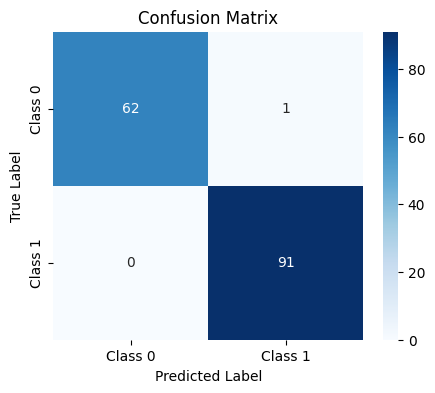

In [41]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Get model predictions (probabilities)
y_pred_prob = model_1.predict(test_X)

# Convert probabilities to class labels (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# If your labels are one-hot encoded, convert them back to single-class
test_Y_labels = np.argmax(test_Y, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_Y_labels, y_pred_labels)
print("Confusion Matrix:\n", cm)

# Print detailed classification report (includes F1-score)
print("\nClassification Report:\n", classification_report(test_Y_labels, y_pred_labels))


plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
